# 配送計画システムMETRO VI

> 配送計画システム METRO とその使用法

In [ ]:
#| default_exp metro

In [ ]:
#| hide
%reload_ext autoreload
%autoreload 2

In [1]:
#| export
import sys
sys.path.append('..')
from scmopt2.core import *
from scmopt2.mypulp import GRB, quicksum
from scmopt2.mypulp import Model as PulpModel

from typing import List, Optional, Union, Tuple, Dict, Set, Any, DefaultDict, Sequence
from pydantic import BaseModel, Field, ValidationError, validator, confloat, conint, constr, Json
from pydantic.tools import parse_obj_as
from datetime import datetime, date, time
import networkx as nx
import copy
import pickle
from collections import defaultdict
import numpy

import glob
import sys
import os 
import re
import random
import requests
import matplotlib.pyplot as plt
import math
import pandas as pd
import datetime as dt
from collections import namedtuple, OrderedDict
import json
import plotly.figure_factory as ff
import plotly.express as px
import plotly
from plotly.graph_objs import *
import numpy as np
from IPython.display import Image
from pprint import pprint
import ast
import subprocess
import platform
import polyline #nbdevと相性が悪いので，pipで入れる．
from faker import Faker

from openpyxl import Workbook, load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.chart import ScatterChart, Reference, Series
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
from openpyxl.styles import Color, PatternFill, Font, Border, Alignment
from openpyxl.styles.borders import Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.comments import Comment

from pyvrp import Model as PyvrpModel #モデルは別名でインポート
from pyvrp import (
  GeneticAlgorithm,
  Population, 
  PenaltyManager,
  read,
  Solution, #これも別名にする必要がある！
  Route, 
  CostEvaluator,
  Client, 
  ProblemData, 
  VehicleType, 
  RandomNumberGenerator,
)

from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
    plot_time_windows,
    plot_demands,
    plot_solution
)
from pyvrp.stop import MaxIterations, MaxRuntime, NoImprovement

from pyvrp.crossover import selective_route_exchange as srex

from pyvrp.diversity import broken_pairs_distance

from pyvrp.search import (
    LocalSearch,
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    compute_neighbours,
)

host = "test-osrm-intel.aq-cloud.com"
#host = "localhost"
folder = "./data/metroIV/"
mapbox_access_token = 'pk.eyJ1IjoibWlraW9rdWJvIiwiYSI6ImNqYXQ3dHBqdzR5ZGwyd3BkeG5rOTl0b2UifQ.1utsXNi2V-WdzfWlvCMj_A'

## はじめに

配送計画モデルは，我が国では最も普及しているロジスティクス・ツールである配送計画システムの基幹を成すモデルである．
本来ならば，配送だけでなく集荷にも使われるので**運搬経路問題**（vehicle routing problem）と
よぶのが学術用語としては正しい使い方だが，「運搬」という言葉のイメージが悪いためか，
実務家および研究者の間でも「配送計画」とよばれることが多いので，ここでもそれにならうものとする．

一般に，古典的な配送計画モデルの基本形は以下の仮定をもつ．

- デポとよばれる特定の地点を出発した運搬車が，顧客を経由し再びデポに戻る．このとき運搬車による顧客の通過順をルートとよぶ．
- デポに待機している運搬車の種類および最大積載重量は既知である．
- 顧客の位置は既知であり，各顧客の需要量も事前に与えられている．
- 地点間の移動時間，移動距離，移動費用は既知である．
- 1つのルートに含まれる顧客の需要量の合計は運搬車の最大積載重量を超えない．
- 運搬車の台数は，決められた上限を超えない．（超過した運搬車に対するレンタル料を考える場合や，ルートに含めない顧客に対するペナルティを与える場合もある．）
- 運搬車の稼働時間が与えられた上限を超えない．（超過時間を残業費用として考える場合もある．）

配送計画の応用としては，小売店への配送計画，スクールバスの巡回路決定，郵便や新聞の配達，ゴミの収集，燃料の配送などがある．
もちろん，これらの応用に適用する際には，上の基本条件に新たな条件を付加する必要がある．

ここで考えるのは，ほとんどの実際問題を解けるようにするために，以下の一般化をした配送計画モデルである．

- 複数時間枠制約
- 多次元容量非等質運搬車
- 配達・集荷
- 積み込み・積み降ろし
- 複数休憩条件
- スキル条件
- 優先度付き
- パス型許容
- 複数デポ（運搬車ごとの発地，着地）


## 基本データ

### 地点 node

地点は顧客，積み込み積み下ろし地点，運搬車の発着地を順に並べたものである．最適化に使うのは経度・緯度の情報を保持したlocation列だけである．
移動時間の計算に地図を使用する場合には，以下のデータフレームで保持しているので必要はない．

移動時間を地図で計算しない場合には，この地点の番号を参照し，移動時間を計算したデータ（移動時間データ）を参照する．

例題においては，地点データの番号は以下の順に保管されている．

- ジョブ job に対応する顧客
- 輸送 shipment の積み込み地点に対応する顧客
- 輸送 shipment の積み降ろし地点に対応する顧客
- 運搬車のデポ

したがって，地点の数は，「ジョブ数 $+$ 輸送数 $\times 2 +$ デポ数」となる．

In [ ]:
node_df = pd.read_csv(folder +"node.csv", index_col=0)
node_df.tail()

,name,zip,都道府県,市区町村,大字,location
4,合同会社山田水産,2820021,千葉県,成田市,駒井野（成田国際空港内）,"[140.36806495,35.77641112]"
5,有限会社吉田食品,2992416,千葉県,南房総市,富浦町青木,"[139.8874225,35.06991256]"
6,有限会社青山鉱業,2700001,千葉県,松戸市,幸田,"[139.92525888,35.84571653]"
7,有限会社喜嶋建設,2720134,千葉県,市川市,入船,"[139.92142527,35.67868735]"
8,有限会社工藤水産,2830048,千葉県,東金市,幸田,"[140.38179168,35.53855767]"


### ジョブ job

ジョブは，荷物の集荷もしくは配達を希望している地点の総称であり，以下の列から構成される．

- name: 地点の名称；例題では仮想の名前を入れているが，重複している場合もあるので注意されたい．
- service: 作業時間（以下では時間の単位は全て秒であり，整数値をとるものとする．）
- pickup: 集荷量を表す整数値のリスト．荷量は複数の属性をもつ場合があるので，リストとして表現している．たとえば，重量，容積，パレット数にそれぞれ上限がある場合には，3次元のリスト（ベクトル）として入力する．
- delivery： 配達量を表す整数値のリスト
- time_windows： 時間枠（作業開始可能時刻，終了時刻の組）を表すリストのリスト．複数の時間枠を表すことができる．
たとえば，午前中と午後に作業が可能で，昼の時間帯には作業不能である顧客に対しては， [[8:00,12:00],[13:00,17:00] ]の時刻を基準時刻からの秒に換算したものを入力する．
すなわち8時を基準とした場合には，[[0,14400], [18000, 32400] ] と入力する．
- location: 経度と緯度（浮動小数点数）から構成されるリスト．地図データを用いる場合には，これらの値を用いて移動時間を計算する．
- location_index: 移動時間データを用いる場合の地点に対応する番号． 地図データを用いる場合には使用しない．
- skills: ジョブを遂行するために必要なスキルを表す整数のリスト．少なくとも1つのスキルを定義する必要がある． 運搬車がジョブを処理可能か否かを判定するときに用いられる．
運搬車はジョブが要求するすべてのスキルをもたないと処理できない．
たとえば，4トン車と10トン車の2種類の運搬車があり，10トン車では入れない顧客がいる場合を考える． 
10トン車では入庫不能な顧客（ジョブ）に対してはスキルを [0,1] と定義し， 入れる顧客に対しては [0] と定義する． 
4トン車のスキルを [0,1] と，10トン車のスキルを [0] と定義すれば，10トン車はスキル1をもたないので，入庫不能な顧客を処理することができないことが表現できる．
- priority: ジョブの優先度を表す [0,100] の整数値．ジョブを処理しない（どの運搬車にも割り当てない）としたときに支払われるペナルティを表す．優先度が大きいジョブほど運搬車に割り当てられる（処理される）可能性が高くなる．

In [ ]:
job_df = pd.read_csv(folder+"job.csv",index_col=0) 
job_df.head()

,name,service,pickup,delivery,time_windows,location,location_index,skills,priority
0,合同会社藤本建設,1068,[56],[244],"[[10820, 12620], [33575, 35375]]","[140.37645821,35.73859296]",0,"[0,1]",9
1,有限会社西之園運輸,852,[75],[229],"[[8151, 9951], [21049, 22849]]","[140.26801893,35.69354415]",1,"[0,1]",9
2,株式会社村山印刷,1090,[100],[683],"[[753, 2553], [27719, 29519]]","[140.07757664,35.654959999999996]",2,[0],7
3,青田印刷合同会社,998,[70],[849],"[[11742, 13542], [19888, 21688]]","[139.85405777,35.14919189]",3,[0],6
4,合同会社山田水産,1162,[87],[608],"[[1110, 2910], [24285, 26085]]","[140.36806495,35.77641112]",4,[0],9


### Jobクラス 

- id: ジョブを区別するための整数値
- location: 経度と緯度（浮動小数点数）から構成されるリスト．地図データを用いる場合には，これらの値を用いて移動時間を計算する．
- location_index: 移動時間データを用いる場合の地点に対応する番号． 地図データを用いる場合には使用しない．
- setup: 作業の準備時間（以下では時間の単位は全て秒であり，整数値をとるものとする．）
- service: 作業時間
- delivery： 配達量を表す整数値のリスト；荷量は複数の属性をもつ場合があるので，順序型として表現する．たとえば，重量，容積，パレット数にそれぞれ上限がある場合には，3次元のリスト（ベクトル）として入力する．
- pickup: 集荷量を表す整数値のリスト
- skills: ジョブを遂行するために必要なスキルを表す整数のリスト．少なくとも1つのスキルを定義する必要がある． 運搬車がジョブを処理可能か否かを判定するときに用いられる．
運搬車はジョブが要求するすべてのスキルをもたないと処理できない．
たとえば，4トン車と10トン車の2種類の運搬車があり，10トン車では入れない顧客がいる場合を考える． 
10トン車では入庫不能な顧客（ジョブ）に対してはスキルを [0,1] と定義し， 入れる顧客に対しては [0] と定義する． 
4トン車のスキルを [0,1] と，10トン車のスキルを [0] と定義すれば，10トン車はスキル1をもたないので，入庫不能な顧客を処理することができないことが表現できる．
- priority: ジョブの優先度を表す [0,100] の整数値．ジョブを処理しない（どの運搬車にも割り当てない）としたときに支払われるペナルティを表す．優先度が大きいジョブほど運搬車に割り当てられる（処理される）可能性が高くなる．
- time_windows： 時間枠（作業開始可能時刻，終了時刻の組）を表す長さ2のタプルの順序型．複数の時間枠を表すことができる．
たとえば，午前中と午後に作業が可能で，昼の時間帯には作業不能である顧客に対しては， [[8:00,12:00],[13:00,17:00] ]の時刻を基準時刻からの秒に換算したものを入力する．
すなわち8時を基準とした場合には，[[0,14400], [18000, 32400] ] と入力する．
- description: 名称などを文字列として入力する．

In [ ]:
#| export
MAX_UINT = int(numpy.iinfo(numpy.uintp).max)
MAX_INT = int(numpy.iinfo(numpy.intp).max)

class Entity(BaseModel):
    def __str__(self) -> str:
        repr = {k: v for k, v in self.model_dump().items() if k in self.model_fields_set}
        return str(repr)
        
class Job(Entity):
    id: int
    location: Union[None, Sequence[float]] = None #経度・緯度 [lon, lat] を入れる場合
    location_index: Union[None, int] = None       #行列のインデックスを入れる場合
    setup: Optional[int] = 0
    service: Optional[int] = 0
    delivery: Optional[Sequence[int]] = [0]
    pickup: Optional[Sequence[int]]  = [0]
    skills: Optional[Set[int]] = None
    priority: Optional[int] = 0
    time_windows: Optional[Sequence[Tuple[int, int]]] = None
    description: Optional[str] = ""

In [ ]:
job1 = Job(id=1414, location_index=0)
job1.model_dump_json(exclude_none=True)

'{"id":1414,"location_index":0,"setup":0,"service":0,"delivery":[0],"pickup":[0],"priority":0,"description":""}'

### 輸送 shipment

輸送は，運搬車のデポ（出発地点もしくは最終到着地点）以外での荷物の積み込みと積み降ろしを表し，以下の列から構成される．

- amount: 積み込み地点で積み込み，積み降ろし地点で降ろす量（輸送量）．整数値のリスト
- pickup_point: 積み込み地点の名称
- pickup_service: 積み込みにかかる作業時間
- pickup_time_windows: 積み込みの時間枠を表すリストのリスト
- pickup_location: 積み込み地点の経度・緯度のリスト
- pickup_index: 移動時間データを用いる場合の積み込み地点に対応する番号． 地図データを用いる場合には使用しない．
- delivery_point: 積み降ろし地点の名称
- delivery_service: 積み降ろしにかかる作業時間
- delivery_time_windows: 積み降ろしの時間枠を表すリストのリスト
- delivery_location: 積み降ろし地点の経度・緯度のリスト
- delivery_index: 移動時間データを用いる場合の積み降ろし地点に対応する番号． 地図データを用いる場合には使用しない．
- skills: 輸送を行うために必要なスキル
- priority: 優先度


In [ ]:
shipment_df = pd.read_csv(folder +"shipment.csv", index_col=0) 
shipment_df.head()

,amount,pickup_point,pickup_service,pickup_time_windows,pickup_location,pickup_index,delivery_point,delivery_service,delivery_time_windows,delivery_location,delivery_index,skills,priority
0,[38],有限会社吉田食品,835,"[[7935, 9735], [18905, 20705]]","[139.8874225,35.06991256]",5,有限会社青山鉱業,672,"[[10863, 12663], [33913, 35713]]","[139.92525888,35.84571653]",6,[0],0


### ShipmentStepクラス

- id: ジョブを区別するための整数値
- location: 経度と緯度（浮動小数点数）から構成されるリスト．地図データを用いる場合には，これらの値を用いて移動時間を計算する．
- location_index: 移動時間データを用いる場合の地点に対応する番号． 地図データを用いる場合には使用しない．
- setup: 作業の準備時間（以下では時間の単位は全て秒であり，整数値をとるものとする．）
- service: 作業時間
- time_windows： 時間枠（作業開始可能時刻，終了時刻の組）を表す長さ2のタプルの順序型．複数の時間枠を表すことができる．
- description: 名称などを文字列として入力する．


### Shipmentクラス

- pickup: 積み込み地点のShipmentStep
- delivery_point: 積み降ろし地点のShipmentStep
- amount: 積み込み地点で積み込み，積み降ろし地点で降ろす量（輸送量）．整数値の順序型．
- skills: 輸送を行うために必要なスキル
- priority: 優先度


In [ ]:
#| export
class ShipmentStep(Entity):
    id: int
    location: Optional[ Tuple[float,float] ] = None
    location_index: Optional[ int ] = None
    setup: Optional[ int ] = 0
    service: Optional[ int ] = 0
    time_windows: Optional[ Sequence[Tuple[int, int]] ] = None
    description: Optional[ str ] = ""

class Shipment(Entity):
    pickup: ShipmentStep
    delivery: ShipmentStep
    amount: Optional[Sequence[int]] = [0]
    skills: Optional[Set[int]] = None
    priority: Optional[int] = 0

### 休憩 break

- description: 休憩の説明
- time_windows: 休憩をとる時間枠（（最早時刻と最遅時刻の組(タプル)）のリスト
- service: 休憩時間

In [ ]:
break_df = pd.DataFrame( {"description":["lunch", "supper"], "time_windows": ["[(10800,18000)]","[(32400,39600)]"], 
                          "service": [3600,1800]} )
#break_df.to_csv(folder+"break.csv")
break_df

,description,time_windows,service
0,lunch,"[(10800,18000)]",3600
1,supper,"[(32400,39600)]",1800


### Breakクラス

- id: 休憩を区別するための整数値
- time_windows: 休憩をとる時間枠（最早時刻と最遅時刻のタプル）の順序型
- service: 休憩時間
- description: 休憩の説明
- max_load: 休憩をとることが可能な最大積載量を表す整数の順序型

In [ ]:
#| export
class Break(Entity):
    id: int
    time_windows: Optional[ Sequence[ Tuple[int, int] ] ]= []
    service: Optional[ int ] = 0
    description: Optional[ str ] = ""
    max_load: Optional[ Sequence[int] ] = None

In [ ]:
temp = []
for id, row in enumerate(break_df.itertuples()):
    #print(ast.literal_eval(row.time_windows))
    temp = {"id":id,
             "description": row.description, 
             "time_windows": ast.literal_eval(row.time_windows),
             "service": row.service
              }
    b = Break(**temp) 
b

Break(id=1, time_windows=[(32400, 39600)], service=1800, description='supper', max_load=None)

### 運搬車 vehicle

運搬車（トラック，車両）は，輸送手段の総称であり， 以下の列をもつ．

- name: 運搬車を区別するための名称
- start: 運搬車の出発地点を表す経度・緯度のリスト．(start_indexで点の番号を参照させ，移動時間行列を与える方法も可能である．） 省略した場合には，最初の訪問地点から出発する．
- start_index: 移動時間データを用いる場合の運搬車の出発地点に対応する番号． 地図データを用いる場合には使用しない． このデータが空 (NaN) の場合には，出発地点を指定せず，最初に訪問した地点から運搬車の経路が開始される．
- end: 運搬車の最終到着地点を表す経度・緯度のリスト． 省略した場合には，最後の訪問地点で終了する． ただし，出発地点と最終到着地点の両者を省略することはできない． 出発地点と同じ座標にした場合には，出発地点であるデポに戻ることを表す．
- end_index: 移動時間データを用いる場合の運搬車の最終到着地点に対応する番号． 地図データを用いる場合には使用しない． このデータが空 (NaN) の場合には，最終到着地点を指定せず，最後に訪問した地点で運搬車の経路が終了する．
もちろん出発地点と最終到着地点が異なっても良い．そのため，複数デポや最終地点が車庫であることも表現できる．
- capacity: 運搬車の積載量上限（容量）を表す整数値のリスト．ジョブデータの集荷量・配達量，輸送データの輸送量と同じ長さのリスト（ベクトル）である必要がある．
- time_window: 運搬車の時間枠（最早開始時刻と最遅到着時刻の組）を表すリスト
- skills: 運搬車のもつスキル． ジョブや輸送で要求するすべてのスキルをもたないと処理できない．
- breaks: 休憩の番号のリスト．既定値は「なし」を表す None． 例における休憩データの場合で，昼食だけの場合は[0]，昼食と夕食の場合は[0,1]と設定する．

In [ ]:
vehicle_df = pd.read_csv(folder +"vehicle.csv", index_col=0) 
vehicle_df.head()

,name,start,start_index,end,end_index,capacity,time_window,skills,breaks
0,truck0,"[139.92142527,35.67868735]",7,[],NaN,[2209],"[0, 36000]","[0,1]",[]


### Vehicleクラス

- id: 運搬車を区別するための整数値
- start: 運搬車の出発地点を表す経度・緯度のタプル．(start_indexで点の番号を参照させ，移動時間行列を与える方法も可能である．） 省略した場合には，最初の訪問地点から出発する．
- end: 運搬車の最終到着地点を表す経度・緯度の順序型． 省略した場合には，最後の訪問地点で終了する． ただし，出発地点と最終到着地点の両者を省略することはできない． 出発地点と同じ座標にした場合には，出発地点であるデポに戻ることを表す．
- start_index: 移動時間データを用いる場合の運搬車の出発地点に対応する番号． 地図データを用いる場合には使用しない． このデータが空 (NaN) の場合には，出発地点を指定せず，最初に訪問した地点から運搬車の経路が開始される．
- end_index: 移動時間データを用いる場合の運搬車の最終到着地点に対応する番号． 地図データを用いる場合には使用しない． このデータが空 (NaN) の場合には，最終到着地点を指定せず，最後に訪問した地点で運搬車の経路が終了する．
もちろん出発地点と最終到着地点が異なっても良い．そのため，複数デポや最終地点が車庫であることも表現できる．
- profile: 運搬車の種類（プロファイル）を表す文字列．既定値は "car" だが， "bicycle", "walk", "truck" などと指定すると， 該当する移動時間や費用を使うことができる．これによって運搬車ごとの移動時間や費用の違いを表現できる．
- capacity: 運搬車の積載量上限（容量）を表す整数値のリスト．ジョブデータの集荷量・配達量，輸送データの輸送量と同じ長さの順序型である必要がある．
- time_window: 運搬車の時間枠（最早開始時刻と最遅到着時刻の組）を表す長さ2のタプル
- skills: 運搬車のもつスキル． ジョブや輸送で要求するすべてのスキルをもたないと処理できない．
- breaks: 休憩を表すインスタンスの順序型
- description: 名称などを文字列として入力する．
- costs: VehicleCostsのインスタンス（固定費用 fixed，1時間あたりの費用 per_hour，1kmあたりの費用 per_km を設定できる．） これによって，運搬車ごとに異なる費用を，簡単に表現できる．
- speed_factor: 既定値の速度の何倍かを表す浮動小数点数．既定値は $1.0$． これを使うと，運搬車ごとに異なる移動時間をもつことを，簡易的に表現することができる．
- max_tasks: 処理可能なジョブ数の上限
- max_travel_time: 最大稼働時間


In [ ]:
#| export
class VehicleCosts(Entity):
    fixed: Optional[int] = 0
    per_hour: int = 3600
    per_km:Optional[int] = 0

class VEHICLE_STEP_TYPE(Entity):
    START: str = "start"
    END: str = "end"
    BREAK: str = "break"
    SINGLE: str = "single"
    PICKUP: str = "pickup"
    DELIVERY: str = "delivery"

class VehicleStep(Entity):
    step_type: VEHICLE_STEP_TYPE
    id: Optional[int] = None
    service_at: Optional[int] = None
    service_after: Optional[int] = None
    service_before: Optional[int] = None
    
class Vehicle(Entity):
    id: int
    start: Union[None, Sequence[float]] = None
    end: Union[None, Sequence[float]] = None
    start_index: Union[None, int] = None
    end_index: Union[None, int] = None
    profile: Optional[ str ] = "car"
    capacity: Optional[ Union[Sequence[int]] ] = None
    skills: Optional[Set[int]] = None
    time_window: Optional[Tuple[int, int]] = None
    breaks: Optional[Sequence[Break]] = None
    description: str = ""
    costs: VehicleCosts = VehicleCosts()
    speed_factor: Optional[ float ] = 1.0
    max_tasks: Optional[ int ]= None
    max_travel_time: Optional[int] = None
    steps: Sequence[VehicleStep] = None

In [ ]:
vehicle = Vehicle(id=7, start_index=0, end_index=0, time_window=(0,100), costs = VehicleCosts(per_hour=10) )
#eval(repr(vehicle))
print(vehicle.model_dump_json(exclude_none=True))

{"id":7,"start_index":0,"end_index":0,"profile":"car","time_window":[0,100],"description":"","costs":{"fixed":0,"per_hour":10,"per_km":0},"speed_factor":1.0}


### Matrixクラス

- durations: 移動時間を表す行列（リストのリスト）
- distances: 移動距離を表す行列（リストのリスト）
- costs: 移動費用を表す行列（リストのリスト）

In [ ]:
#| export
class Matrix(Entity):
    durations: List[List] = None
    distances: List[List] = None
    costs: List[List] = None

### Modelクラス

配送計画モデルを表すクラス

- jobs: Jobインスタンスの順序型
- shipments: Shipmentインスタンスの順序型
- vehicles: Vehicleクラスの順序型
- matrices: 運搬車のプロファイルを表す文字列をキーとし，Matrixクラスのインスタンスを値とした辞書

In [ ]:
#| export
class Model(Entity):
    jobs: Optional[Sequence[Job]]             = Field( description="ジョブたち", default=None )
    shipments: Optional[Sequence[Shipment]]   = Field( description="輸送たち", default=None )
    vehicles: Optional[Sequence[Vehicle]]     = Field( description="運搬車たち", default=None )
    matrices: Optional[Dict[str,Matrix]]      = Field( description="行列たち", default=None )

In [ ]:
break0 =Break(id=0, time_windows = [(1000,2000)], service = 100, max_load=[20])

model = Model()
model.vehicles= [Vehicle(id=7, start_index=0, end_index=0, capacity=[100], time_window=[0,20000], 
                         costs = VehicleCosts(fixed=99999), breaks=[break0]), 
                 Vehicle(id=8, start_index=2, end_index=2, capacity=[100],breaks=[break0])]
model.jobs = [ Job(id=1, location_index=0, delivery=[10], pickup=[30], time_windows=[(0,100),(300,10000)]),
               Job(id=12, location_index=1, delivery=[20]),
                Job(id=1616, location_index=2, delivery=[30]),
                Job(id=1717, location_index=3, delivery=[40])]
model.matrices = {"car": Matrix(
                                durations= [[0, 2104, 197, 1299],
                                            [2103, 0, 2255, 3152],
                                            [197, 2256, 0, 1102],
                                            [1299, 3153, 1102, 0]]
                                )
                 }
model.shipments=[Shipment(pickup=ShipmentStep(id=1, location_index=2),
                   delivery=ShipmentStep(id=124, location_index=3, time_windows=[ (500,2000) ]),
                   amount=[10])]
model.model_dump_json(exclude_none=True)

'{"jobs":[{"id":1,"location_index":0,"setup":0,"service":0,"delivery":[10],"pickup":[30],"priority":0,"time_windows":[[0,100],[300,10000]],"description":""},{"id":12,"location_index":1,"setup":0,"service":0,"delivery":[20],"pickup":[0],"priority":0,"description":""},{"id":1616,"location_index":2,"setup":0,"service":0,"delivery":[30],"pickup":[0],"priority":0,"description":""},{"id":1717,"location_index":3,"setup":0,"service":0,"delivery":[40],"pickup":[0],"priority":0,"description":""}],"shipments":[{"pickup":{"id":1,"location_index":2,"setup":0,"service":0,"description":""},"delivery":{"id":124,"location_index":3,"setup":0,"service":0,"time_windows":[[500,2000]],"description":""},"amount":[10],"priority":0}],"vehicles":[{"id":7,"start_index":0,"end_index":0,"profile":"car","capacity":[100],"time_window":[0,20000],"breaks":[{"id":0,"time_windows":[[1000,2000]],"service":100,"description":"","max_load":[20]}],"description":"","costs":{"fixed":99999,"per_hour":3600,"per_km":0},"speed_fac

## 最適化関数 optimize_vrp

引数：
- model: 最適化モデルを入れた辞書
- matrix = False: 移動時間データを用いる場合True
- thread: 最適化に使用するスレッド数
- explore: 探索の度合いを表すパラメータ； 0から5の整数で，大きいほど念入りに探索する．
- cloud: 複数人が同時実行する可能性があるときTrue（既定値はFalse）; Trueのとき，ソルバー呼び出し時に生成されるファイルにタイムスタンプを追加し，計算終了後にファイルを消去する．
- osrm: OSRMを外部のサーバーで呼び出しをしたいときTrue， localhostで呼び出すときFalse


返値：
- input_dic: データ入力のためのJSONデータ
- output_dic: 結果出力のためのJSONデータ
- error: エラーメッセージを入れた文字列 


In [ ]:
#| export
def optimize_vrp(model, matrix=False, threads = 4, explore = 5, cloud = False, osrm=False, host="localhost"):
    # 呼び出し方法
    #./metroVI  -g -i test1.json -o output1.json -a car:test-osrm-intel.aq-cloud.com
    
    if cloud:
        time_stamp= dt.datetime.now().timestamp()
    else:
        time_stamp = 1

    with open(f"test{time_stamp}.json", 'w') as f:
        f.write(model.model_dump_json(exclude_none=True))

    if cloud:
        import pathlib
        p = pathlib.Path(".") #現在のフォルダ
        script = p / "scripts/metroVI"
    else:
        script = "./metroVI"
    
    if platform.system() == "Windows":
        if matrix:
            cmd = f"metro-win -i test{time_stamp}.json -o output{time_stamp}.json"
        else:
            cmd = f"metro-win - g -i test{time_stamp}.json -o output{time_stamp}.json"
    elif platform.system() == "Darwin":
        if platform.processor()[0]=="i": #intel 
            if matrix:
                cmd = f"{script}-mac-intel -i test{time_stamp}.json -o output{time_stamp}.json"
            else:
                if osrm:
                    cmd = f"{script}-mac-intel -g -i test{time_stamp}.json -o output{time_stamp}.json -a car:{host}"
                else:
                    cmd = f"{script}-mac-intel -g -i test{time_stamp}.json -o output{time_stamp}.json"
        elif platform.processor()[0]=="a": #arm 
            if matrix:
                cmd = f"{script}-mac-sillicon -i test{time_stamp}.json -o output{time_stamp}.json"
            else:
                if osrm:
                    cmd = f"{script}-mac-sillicon -g -i test{time_stamp}.json -o output{time_stamp}.json -a car:{host}"
                else:
                    cmd = f"{script}-mac-sillicon -g -i test{time_stamp}.json -o output{time_stamp}.json"
        else:
            print(f"{platform.system()} and {platform.processor()} may not be supported.")
            return -1
                
    elif platform.system() == "Linux": #cloud=Trueを仮定
        if matrix:
            cmd = f"{script}-linux-intel -i test{time_stamp}.json -o output{time_stamp}.json"
        else:
            if osrm:
                cmd = f"{script}-linux-intel -g -i test{time_stamp}.json -o output{time_stamp}.json -a car:{host}"
            else:
                cmd = f"{script}-linux-intel -g -i test{time_stamp}.json -o output{time_stamp}.json"
    else:
        print(platform.system(), "may not be supported.")
        return -1

    cmd +=  " -t " + str(threads) + " -x " + str(explore)
    # -g,                              add detailed route geometry and indicators
    # -t THREADS (=4),                 number of threads to use
    # -x EXPLORE (=5),                 exploration level to use (0..5)
 
    try:
        print("Now solving ...")
        o = subprocess.run(cmd.split(), check=True, capture_output=True)
        #print(o.stdout)
        print("Done")
    except subprocess.CalledProcessError as e:
        #print('ERROR:',e.stderr) # ERROR
        return "", "", e.stderr

    example1_in = open(f'test{time_stamp}.json', 'r')
    input_dic = json.load(example1_in)

    example1_out = open(f'output{time_stamp}.json', 'r')
    output_dic = json.load(example1_out)
    try:
        error =  output_dic["error"]
    except:
        error = ""
    if cloud:
        os.remove( p / f'test{time_stamp}.json')
        os.remove( p / f'output{time_stamp}.json')

    return input_dic, output_dic, error  #errorを返す

In [ ]:
input_dic, output_dic, error = optimize_vrp(model, matrix=True, explore=5, cloud=False, osrm=True, host=host)

Now solving ...
Done


### Solutionクラス


In [ ]:
#| export
class Summary(Entity):
    cost: int #	total cost for all routes
    routes: int #	number of routes in the solution
    unassigned: int #	number of tasks that could not be served
    setup: int #	total setup time for all routes
    service: int #	total service time for all routes
    duration: int 	#total travel time for all routes
    waiting_time: int	#total waiting time for all routes                                
    priority: int	#total priority sum for all assigned tasks
    violations: Optional[Sequence[str]]	#array of violation objects for all routes
#[amount]	total amount for all routes
    delivery: Optional[Sequence[int]]	#total delivery for all routes
    pickup:  Optional[Sequence[int]] 	#total pickup for all routes
    distance: Optional[int]	 =None           #total distance for all routes: provided when using the -g flag.

class Violation(Entity):
    cause: str  
    duration: Optional[int] =None
# "delay" if actual service start does not meet a task time window and is late on a time window end
# "lead_time" if actual service start does not meet a task time window and is early on a time window start
# "load" if the vehicle load goes over its capacity
# "max_tasks" if the vehicle has more tasks than its max_tasks value
# "skills" if the vehicle does not hold all required skills for a task
# "precedence" if a shipment precedence constraint is not met (pickup without matching delivery, delivery before/without matching pickup)
# "missing_break" if a vehicle break has been omitted in its custom route
# "max_travel_time" if the vehicle has more travel time than its max_travel_time value
# "max_load" if the load during a break exceed its max_load value

class Route(Entity):
    vehicle: int #	id of the vehicle assigned to this route
    steps: Optional[Sequence[Any]]	#array of step objects
    cost: int  #cost for this route
    setup: int #	total setup time for this route
    service: int #	total service time for this route
    duration: int #	total travel time for this route
    waiting_time: int #	total waiting time for this route
    priority: int #	total priority sum for tasks in this route
    violations: Optional[Sequence[Violation]]=None	#array of violation objects for this route
    #amount: Optional[Sequence[int]]	#total amount for jobs in this route
    delivery: Optional[Sequence[int]] =None	#total delivery for tasks in this route
    pickup: Optional[Sequence[int]] =None	 #total pickup for tasks in this route
    description: str =None #vehicle description, if provided in input
    geometry: Optional[str] = None #*	polyline encoded route geometry
    distance: Optional[int] = None #*

class Solution(Entity):
    code: int	#status code
    error: Optional[str] =None	  #error message (present iff code is different from 0)
    summary: Optional[Summary] =None #object summarizing solution indicators
    unassigned: Optional[Sequence[Any]]  =None	#array of objects describing unassigned tasks with their id, type, and if provided, description, location and location_index
    routes: Optional[Sequence[Route]] =None	#array of route objects

### 解の情報を計算する関数 make_solution

引数：

- output_dic: 最適化の結果を格納した辞書

返値：

- summary_df: 解の概要のデータフレーム
- route_summary_df: ルートの概要のデータフレーム
- unassigned_df: 未割り当てのジョブ・輸送のデータフレーム
- route_df_dic: キーをルート番号とし，ルートの情報を格納したデータフレームを値とした辞書．
  ルートデータフレームの列は以下の通り．

     - index: 訪問順序
     - type: 地点名（開始地点はstart，終了地点はend，ジョブはjob，輸送の積み込み地点はpickup，積み降ろし地点はdelivery，休憩はbreakと表示される．）
     - cost: ルートの費用
     - location: 経度・緯度
     - location_index: 地点インデックス
     - setup: 準備時間
     - service: 作業時間
     - waiting_time: 待ち時間
     - load: その地点での積載量を表すリスト
     - arrival: 到着時刻
     - duration: 累積移動時間
     - priority: 優先度の合計
     - violations: 制約逸脱量
     - delivery: 配達量の合計
     - pickup: 積み込み量の合計
     - description: 概要
     - geometry: ルート詳細のpolyline
     - distance: 総走行距離
     - id: ジョブ・輸送の番号
     - job: ジョブ

In [ ]:
#| export
def make_solution(output_dic:dict) -> tuple:
    
    solution = Solution.model_validate(output_dic)
    sol_dict = solution.model_dump()
    summary_df = pd.DataFrame.from_dict(sol_dict["summary"], orient='index').T

    if len(sol_dict["routes"])>0:
        dfs = []
        for r in sol_dict["routes"]:
            df = pd.DataFrame.from_dict(r, orient='index').T
            df.drop("steps", axis=1, inplace=True)
            dfs.append(df)
        route_summary_df = pd.concat(dfs)
        route_summary_df.reset_index(inplace=True)
        route_summary_df.drop("index", axis=1, inplace=True)
    else:
        route_summary_df = None

    if len(sol_dict["unassigned"])>0:
        dfs = []
        for r in sol_dict["unassigned"]:
            df = pd.DataFrame.from_dict(r, orient='index').T
            dfs.append(df)
        unassigned_df = pd.concat(dfs)
        unassigned_df.reset_index(inplace=True)
        unassigned_df.drop("index", axis=1, inplace=True)
    else:
        unassigned_df = None

    route_df_dic = {}
    for r in sol_dict["routes"]:
        if len(sol_dict["routes"])>0:
            dfs= []
            for j in r["steps"]:
                df = pd.DataFrame.from_dict(j, orient='index').T
                dfs.append(df)
            route_df = pd.concat(dfs)
            route_df.reset_index(inplace=True)
            route_df.drop("index", axis=1, inplace=True)
            route_df_dic[ r["vehicle"] ] = route_df
    return summary_df, route_summary_df, unassigned_df, route_df_dic

In [ ]:
output_file = open(f'output1.json', 'r')
output_dic = json.load(output_file)
summary_df, route_summary_df, unassigned_df, route_df_dic = make_solution(output_dic)

## データ生成

### 移動時間行列の計算関数 compute_distance_table_for_vrp

地図アプリ OSRM を用いて移動時間と移動距離を計算する．

引数：
- node_df: ノードデータフレーム（緯度経度情報を含む）
- toll: 有料道路が使用可のときTrue（既定値 True)
- host: ホスト名；既定値は "localhost"

返値：
- durations: 地点間の移動時間の配列
- distances: 地点間の距離の配列

In [ ]:
#| export 
def compute_distance_table_for_vrp(node_df, toll=True, host="localhost"):
    ROUTE =[]
    for row in node_df.itertuples():
        ROUTE.append( ast.literal_eval(row.location) )
    route_str =""
    for (i,j) in ROUTE[:]:
        route_str += str(i)+","+str(j)+";"
        
    if toll:
        response = requests.get(f'http://{host}:5000/table/v1/driving/'+route_str[:-1]+"?annotations=distance,duration")
    else:
        response = requests.get(f'http://{host}:5000/table/v1/driving/'+route_str[:-1]+"?annotations=distance,duration&exclude=toll")
    
    result = response.json()
    #print(result)
    try:
        durations = result["durations"]
        distances = result["distances"]
    except:
        raise ValueError 
    return  durations,  distances

###  compute_distance_table_for_vrp関数の使用例

移動時間と移動距離を計算し，移動時間の度数分布表を描画する．


In [ ]:
node_df = pd.read_csv(folder +"node.csv")
durations,  distances = compute_distance_table_for_vrp(node_df, toll=False, host=host)
node_df.head()

,Unnamed: 0,name,zip,都道府県,市区町村,大字,location
0,0,合同会社藤本建設,2860114,千葉県,成田市,本城,"[140.37645821,35.73859296]"
1,1,有限会社西之園運輸,2850053,千葉県,佐倉市,下勝田,"[140.26801893,35.69354415]"
2,2,株式会社村山印刷,2620021,千葉県,千葉市花見川区,花園町,"[140.07757664,35.654959999999996]"
3,3,青田印刷合同会社,2991902,千葉県,安房郡鋸南町,保田,"[139.85405777,35.14919189]"
4,4,合同会社山田水産,2820021,千葉県,成田市,駒井野（成田国際空港内）,"[140.36806495,35.77641112]"


In [ ]:
#durations[-1] #デポから他の地点への移動時間
node_df["duration"] = durations[-1]
node_df["distance"] = distances[-1]
fig = px.histogram(node_df, x="duration",nbins=30, title ="デポからの移動時間の度数分布表", marginal="violin")
#plotly.offline.plot(fig);

### 地点間の距離と移動時間（高速道路利用の有無あり）のデータフレームを生成する関数 make_time_df_for_vrp

引数：
- node_df: 点のデータフレーム

返値：
- time_df: 発地，着地，移動時間（秒），道路距離（m）,高速なしの移動時間（秒），高速なしの道路距離（m)を入れたデータフレーム

In [ ]:
def make_time_df_for_vrp(node_df, host="localhost"):
    MAX_ = 100000
    try:
        node_df.reset_index(inplace=True)
    except:
        pass
    durations,  distances = compute_distance_table_for_vrp(node_df, toll=True, host=host) #高速利用
    durations2,  distances2 = compute_distance_table_for_vrp(node_df, toll=False, host=host) #高速利用なし
    n = len(durations)
    name_dic = node_df.name.to_dict() #番号を顧客名に写像
    from_id, to_id, duration, distance, duration2, distance2 =[],[],[],[],[],[]
    from_name, to_name = [], [] 
    for i in range(n):
        for j in range(n):
            if durations[i][j] is not None and durations2[i][j] is not None:
                from_id.append(i)
                to_id.append(j)
                from_name.append(name_dic[i])
                to_name.append(name_dic[j])
                duration.append( int(durations[i][j]) )
                distance.append( int(distances[i][j]) )
                duration2.append( int(durations2[i][j]) )
                distance2.append( int(distances2[i][j]) )
            else:
                #距離・時間がない場合
                from_id.append(i)
                to_id.append(j)
                from_name.append(name_dic[i])
                to_name.append(name_dic[j])
                duration.append( MAX_  )
                distance.append( MAX_  )
                duration2.append( MAX_  )
                distance2.append( MAX_  )
                
    time_df = pd.DataFrame({"from_node": from_id, "from_name": from_name, "to_node":to_id,
                            "to_name":to_name, "time": duration, "distance": distance, 
                            "time(no toll)": duration2, "distance(no toll)": distance2 })
    return time_df

In [ ]:
node_df = pd.read_csv(folder +"node10.csv")
time_df = make_time_df_for_vrp(node_df, host)
time_df.head()

,from_node,from_name,to_node,to_name,time,distance,time(no toll),distance(no toll)
0,0,合同会社前田建設 第 18 支店,0,合同会社前田建設 第 18 支店,0,0,0,0
1,0,合同会社前田建設 第 18 支店,1,有限会社阿部運輸 第 73 支店,18927,409022,22105,465388
2,0,合同会社前田建設 第 18 支店,2,株式会社村上印刷 第 98 支店,10696,246981,10696,246981
3,0,合同会社前田建設 第 18 支店,3,佐藤印刷合同会社 第 9 支店,23557,527974,26465,584830
4,0,合同会社前田建設 第 18 支店,4,合同会社青木水産 第 33 支店,20808,474615,23726,521476


### 郵便番号データをもとに日本のノードデータをランダムに生成する関数 generate_node

引数：
- n: 地点数
- random_seed=1：乱数の種
- prefecture=None: 県名
- matrix: 移動時間行列を生成するとき True

返値：
- node_df: 顧客データフレーム
- time_df: 移動時間データフレーム（matrix引数がTrueのとき；それ以外のときは，空の文字列""を返す．）


In [ ]:
#| export
def generate_node(n, random_seed=1, prefecture=None, matrix=False, host=host):
    """
    郵便番号データをもとに日本のノードデータをランダムに生成する関数
    """
    #data_generationで分割して保存した郵便番号データが保存されていると仮定
    input_prefix = "./data/output_chunk_"
    def combine_csv_files(input_prefix):
        # ファイル名パターンに基づいて分割されたCSVファイルのリストを取得
        file_list = glob.glob(input_prefix + "*.csv")
        # 分割されたCSVファイルを読み込んで結合
        combined_df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)
        return combined_df 
        
    df = combine_csv_files(input_prefix)
    Faker.seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    fake = Faker("ja_JP")
    # select customers 
    if prefecture == None:
        # if n> len(df):
        #     print("number of customers is too large! It exceeds the number of zip points in Japan!")
        #     return -1
        # else:
        node_df = df.sample(n=n, random_state=random_seed, replace=True)
    else:
        node_df = df[df.name1 == prefecture]
        # if n> len(node_df):
        #     print("number of customers is too large! Change the prefecture or set to None!")
        #     return -1
        # else:
        node_df = node_df.sample(n=n, random_state=random_seed, replace=True)

    node_df.reset_index(inplace=True)
    node_df.drop("index", axis=1, inplace=True)
    
    fake_name = []
    fake_name_set = set([])
    for _ in range(len(node_df)):
        while 1:
            temp = fake.company() + f" 第 {random.randint(1,100)} 支店" 
            if temp not in fake_name_set:
                fake_name.append(temp)
                fake_name_set.add(temp)
                break
    
    node_df.rename(columns={"name1": "都道府県", "name2": "市区町村", "name3": "大字"}, inplace=True) 
    node_df["name"] = fake_name 
    
    node_df["location"] = "[" + node_df.longitude.astype(str)  + ","+ node_df.latitude.astype(str) +"]"

    if matrix:
        time_df = make_time_df_for_vrp(node_df, host=host)
    else:
        time_df = ""
    
    node_df = node_df.reindex(columns=["name","zip", "都道府県","市区町村","大字","location"])
        
    return node_df, time_df

### generate_node関数の使用例

In [ ]:
# 日本の郵便番号データは分割して保存されているものを内部で読み込む
node_df, time_df = generate_node(n=30, random_seed=1, prefecture="千葉県", matrix=True, host=host)
node_df.head()

,name,zip,都道府県,市区町村,大字,location
0,合同会社近藤保険 第 18 支店,2860121,千葉県,成田市,駒井野（その他）,"[140.37146572,35.77489448]"
1,有限会社鈴木保険 第 73 支店,2617102,千葉県,千葉市美浜区,中瀬ワールドビジネスガーデン（２階）,"[140.0390776,35.64860739]"
2,山田電気株式会社 第 98 支店,2870236,千葉県,成田市,津富浦,"[140.40760995,35.83235231]"
3,有限会社佐藤電気 第 9 支店,2780016,千葉県,野田市,二ツ塚,"[139.91482316,35.93875527]"
4,斎藤保険株式会社 第 33 支店,2893184,千葉県,匝瑳市,栢田,"[140.55222906,35.64056327]"


In [ ]:
time_df.head()

,from_node,from_name,to_node,to_name,time,distance,time(no toll),distance(no toll)
0,0,合同会社近藤保険 第 18 支店,0,合同会社近藤保険 第 18 支店,0,0,0,0
1,0,合同会社近藤保険 第 18 支店,1,有限会社鈴木保険 第 73 支店,1889,39918,2306,45381
2,0,合同会社近藤保険 第 18 支店,2,山田電気株式会社 第 98 支店,642,9559,642,9559
3,0,合同会社近藤保険 第 18 支店,3,有限会社佐藤電気 第 9 支店,2860,56103,2860,56103
4,0,合同会社近藤保険 第 18 支店,4,斎藤保険株式会社 第 33 支店,1634,26391,1634,26391


### ノードデータを正規分布にしたがってランダムに生成する関数 generate_node_normal

引数：
- n: 地点数
- lat_center: 中心緯度
- lon_center: 中心経度
- std: 正規分布の標準偏差
- country_code: 国を表すコード（名称をランダムに生成するときに用いる．） 既定値は日本 ja_JP． その他の国コードについては https://faker.readthedocs.io/en/master/locales.html 参照．
- random_seed=1：乱数の種
- matrix: 移動時間行列を生成するとき True

返値：
- node_df: 顧客データフレーム
- time_df: 移動時間データフレーム（matrix引数がTrueのとき；それ以外のときは，空の文字列""を返す．）


In [ ]:
#| export
def generate_node_normal(n, lat_center, lon_center, std= 0.1, country_code="ja_JP", random_seed=1, matrix=False):
    """
    ノードデータを正規分布にしたがってランダムに生成する関数
    """
    Faker.seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    fake = Faker(country_code)
    
    lat_list = np.random.normal(lat_center,std,n)
    lon_list = np.random.normal(lon_center,std,n)
    fake_name = []
    for _ in range(n):
        fake_name.append(fake.company())

    node_df = pd.DataFrame({"name": fake_name, "longitude": lon_list, "latitude": lat_list})
    
    node_df["location"] = "[" + node_df.longitude.astype(str)  + ","+ node_df.latitude.astype(str) +"]"

    if matrix:
        durations,  distances, _ = compute_durations(node_df)
        time_df = make_time_df(node_df, durations, distances)
    else:
        time_df = ""
        
    node_df = node_df.reindex(columns=["name", "location"])
        
    return node_df, time_df

### generate_node_normal 関数の使用例

In [ ]:
lat_center = 30.567201
lon_center = 120.112051
std = 0.1
country_code = 'zh_CN' #中国
random_seed = 1
node_df, time_df = generate_node_normal(n=10, lat_center=lat_center, lon_center=lon_center, std= std, country_code=country_code, random_seed=1, matrix=False)
node_df.head()

,name,location
0,昊嘉科技有限公司,"[120.25826179370449,30.729635536366324]"
1,菊风公司传媒有限公司,"[119.90603692905023,30.506025358634993]"
2,佳禾传媒有限公司,"[120.07980927959865,30.514383824773656]"
3,晖来计算机传媒有限公司,"[120.07364556453315,30.459904137784385]"
4,新宇龙信息传媒有限公司,"[120.22542794423354,30.65374176293247]"


### モデル構築関数 build_model_for_vrp

データフレームからモデルを生成する関数．

引数：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム
- break_df: 休憩データフレーム
- time_df: 移動時間データフレーム（既定値は「なし」を表すNone）

返値：
- model: METROモデルのインスタンス

In [ ]:
#| export
def build_model_for_vrp(job_df, shipment_df, vehicle_df, break_df, time_df = None, cost_per_hour=3600):
    
    vehicle_L, job_L, shipment_L = [], [], []
    
    if break_df is not None:
        break_L = [ ]
        for i, row in enumerate(break_df.itertuples()):
            break_L.append(  Break(id=i, time_windows= ast.literal_eval(row.time_windows),
                                   service=int(row.service), max_load= None)
                          )
    else:
        break_L = None

    #vehicle
    for i, row in enumerate(vehicle_df.itertuples()):
        temp = {"id":i, 
             "description": row.name, 
             "start": ast.literal_eval(row.start), 
             "start_index":  row.start_index,
             "end": ast.literal_eval(row.end), 
             "end_index":  row.end_index,
             "capacity":ast.literal_eval(row.capacity),
             "time_window":ast.literal_eval(row.time_window),
             "skills":ast.literal_eval(row.skills)}
        if break_L is not None:
             temp["breaks"] =  [ break_L[j] for j in ast.literal_eval(row.breaks)]
            
        if len(ast.literal_eval(row.start))==0:    
            del temp["start"]  #発地点なし             
        if len(ast.literal_eval(row.end))==0:
            del temp["end"]    #着地点なし
        if pd.isnull(row.start_index) or row.start_index==-1:
            del temp["start_index"] 
        if pd.isnull(row.end_index) or row.end_index==-1:
             del temp["end_index"]  
        vehicle_L.append( Vehicle(**temp, costs=VehicleCosts(per_hour=cost_per_hour)) )
        
    #shipment
    if shipment_df is not None:
        for i, row in enumerate(shipment_df.itertuples()):
            temp = {"amount": ast.literal_eval(row.amount),
                 "skills": ast.literal_eval(row.skills),
                 "priority": int(row.priority),
                 "pickup": {"id":len(job_df)+i, 
                            "service": int(row.pickup_service),
                            "location": ast.literal_eval(row.pickup_location),
                             "location_index": row.pickup_index,  
                            "time_windows": ast.literal_eval(row.pickup_time_windows)
                           }, 
                  "delivery": {"id": len(job_df)+len(shipment_df)+i, 
                            "service": int(row.delivery_service),
                            "location": ast.literal_eval(row.delivery_location),
                            "location_index": row.delivery_index,  
                            "time_windows": ast.literal_eval(row.delivery_time_windows)
                           }, 
                 }
            if pd.isnull(row.pickup_index) or row.pickup_index==-1 or pd.isnull(row.delivery_index) or row.delivery_index==-1:
                del temp["pickup"]["location_index"] 
                del temp["delivery"]["location_index"] 
                
            shipment_L.append( Shipment(**temp) )
    
    #job 
    if job_df is not None:
        for i, row in enumerate(job_df.itertuples()):
            temp = {"id":i, 
                 "description": str(row.name), 
                 "location": ast.literal_eval(row.location), 
                 "location_index": row.location_index,
                 "service": int(row.service),
                 "pickup":  ast.literal_eval(row.pickup),
                 "delivery":  ast.literal_eval(row.delivery),
                "time_windows":  ast.literal_eval(row.time_windows),
                "skills":ast.literal_eval(row.skills),
                "priority": int(row.priority)
                }
            if pd.isnull(row.location_index) or row.location_index==-1:
                del temp["location_index"] 
            job_L.append( Job(**temp) )

    if time_df is not None: #移動時間行列を準備
        #n = int(np.sqrt(len(time_df)))
        n = len(node_df)
        duration = np.full((n,n),100000) #移動時間の上限を10万秒に設定
        for (i,j,t) in zip( time_df["from_node"], time_df["to_node"], time_df["time"]):
            duration[i,j] = t
        L = duration.tolist()
        #model["matrix"] = L 
    else:
        L = None
        
    model = Model()
    model.vehicles=  vehicle_L
    model.jobs = job_L
    if L is not None:
        model.matrices = {"car": Matrix(durations=L)}

    model.shipments= shipment_L
    #model.model_dump_json(exclude_none=True)
    #model = {"vehicles": vehicle_L, "jobs": job_L, "shipments": shipment_L}


    return model

### build_model_for_vrp関数の使用例

In [ ]:
# no = "01"
# job_df = pd.read_csv(folder+"job"+no+".csv", index_col=0)
# shipment_df = pd.read_csv(folder+"shipment"+no+".csv", index_col=0)
# vehicle_df = pd.read_csv(folder+"vehicle"+no+".csv", index_col=0)
# time_df = pd.read_csv(folder+"time"+no+".csv", index_col=0)
# break_df = pd.read_csv(folder +"break.csv", index_col=0)
# model = build_model_for_vrp(job_df, shipment_df, vehicle_df,  break_df, time_df, cost_per_hour=1)
# pprint(model.jobs[0])

### 配送計画問題例の生成関数 generate_vrp

配送計画のランダムな問題例を生成する関数

引数：
- node_df: ノードデータフレーム
- num_depots = 1: デポ数
- open_flag = False: Trueだと，運搬車の最終地点がデポでなく，最後の訪問地点となる．
- num_jobs=10: ジョブ数
- num_shipments=0: デポ以外での積み込み積み降ろしの輸送数
- num_time_windows =1: 時間枠の数
- time_window_bounds =(0,36000): 時間枠の下限と上限の組
- time_window_ratio = 0.9: 稼働時間に対する時間枠の比（小さいほど時間枠が狭くなる）
- delivery_bounds = (0,0): 配達量の下限と上限の組
- pickup_bounds = (0,0): 集荷量の下限と上限の組
- service_bounds= (0,0): 作業時間の下限と上限の組
- amount_bounds = (0,0): デポ以外での積み込み積み下ろし量の下限と上限の組
- priority_bounds = (0,100):  優先度の下限と上限の組；0..100の間にする必要がある． 優先度は訪問しない場合のペナルティ量を表す（大きいほどルートに含まれる）．
- load_factor = 0.9: 運搬車の積載率の目標値
- num_customers_per_route = 5： １ルートあたりの配達件数
- skill_flag = False: スキルを考慮した問題例とするときTrue
- breaks = None: 休憩の番号のリスト．既定値は「なし」を表す None． 例における休憩データの場合で，昼食だけの場合は[0]，昼食と夕食の場合は[0,1]と設定する．

返値：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム

In [ ]:
#| export
def generate_vrp(node_df, num_depots = 1, open_flag=False, num_jobs=10, num_shipments=0, num_time_windows =1, time_window_bounds =(0,36000), 
                 time_window_ratio =0.9, delivery_bounds =(0,0), pickup_bounds =(0,0), 
                 service_bounds=(0,0), amount_bounds =(0,0), priority_bounds = (0,100), load_factor = 0.9,
                 num_customers_per_route = 5, skill_flag =False, breaks = None):
    """
    郵便番号データをもとに配送計画問題のデータをランダムに生成する関数（ノード生成を分離）
    """
    n = num_jobs + num_shipments*2 + num_depots #number of points 
    assert n == len(node_df)

    #積み込み積み降ろし (shipment) データフレーム
    # num_job+i => num_jobs + num_shipments + i (i-th shipment) 
    pick_loc, del_loc = [],[]
    pick_name, del_name = [], [] 
    pick_index, del_index =[], []
    for i in range(num_shipments):
        pick_loc.append( node_df.loc[num_jobs+i,"location"] )
        del_loc.append( node_df.loc[num_jobs+num_shipments+i,"location"] )
        pick_name.append( node_df.loc[num_jobs+i,"name"] )
        del_name.append( node_df.loc[num_jobs+num_shipments+i,"name"] )
        pick_index.append(num_jobs+i)
        del_index.append(num_jobs+num_shipments+i)

    shipment_df = pd.DataFrame({"amount": np.random.randint(amount_bounds[0],amount_bounds[1]+1,num_shipments),
                                "pickup_point": pick_name, 
                                "pickup_location": pick_loc,
                                "pickup_index": pick_index, 
                                "pickup_service": np.random.randint(service_bounds[0],service_bounds[1]+1,num_shipments),
                                "delivery_point": del_name, 
                                 "delivery_location": del_loc,
                                 "delivery_index": del_index, 
                                "delivery_service": np.random.randint(service_bounds[0],service_bounds[1]+1,num_shipments)}) 
    shipment_df["amount"] = "[" + shipment_df["amount"].astype(str) +"]"
    
    width = (time_window_bounds[1]-time_window_bounds[0])//num_time_windows #１つの時間枠の設定範囲
    tw_width = int(time_window_ratio*width) #時間枠の幅
    
    pickup_time_windows =[] 
    delivery_time_windows =[] 
    for i in range(num_shipments):
        tw_list =[]
        for i in range(num_time_windows):
            st = np.random.randint(0, (width-tw_width)//2 +1 )
            tw_list.append( [width*i+st, width*i+st+tw_width ] )
        pickup_time_windows.append( str( tw_list ) )
        
        tw_list =[]
        for i in range(num_time_windows):
            st = np.random.randint((width-tw_width)//2, width-tw_width +1 )
            tw_list.append( [width*i+st, width*i+st+tw_width ] )
        delivery_time_windows.append( str( tw_list ) )
    shipment_df["delivery_time_windows"] = delivery_time_windows
    shipment_df["pickup_time_windows"] = pickup_time_windows
    
    skills = []
    for i in range(num_shipments):
        if skill_flag:
            if random.random()<0.5:
                skills.append("[0]")
            else:
                skills.append("[0,1]")
        else:
            skills.append("[0]")
            
    shipment_df["skills"] = skills
    shipment_df["priority"] = np.random.randint(priority_bounds[0],priority_bounds[1]+1,num_shipments)

    #ジョブ (job) データフレーム
    job_df = node_df.loc[:num_jobs-1, ["name", "location"] ]
    job_df["delivery"] = np.random.randint(delivery_bounds[0],delivery_bounds[1]+1,num_jobs) 
    job_df["delivery"] = "[" + job_df["delivery"].astype(str) +"]"
    job_df["pickup"] = np.random.randint(pickup_bounds[0],pickup_bounds[1]+1,num_jobs) 
    job_df["pickup"] = "[" + job_df["pickup"].astype(str) +"]"
    job_df["service"] = np.random.randint(service_bounds[0],service_bounds[1]+1,num_jobs) 
    job_df["location_index"] = [i for i in range(num_jobs)]

    time_windows =[] 
    for i in range(num_jobs):
        tw_list =[]
        for i in range(num_time_windows):
            st = np.random.randint(0, width-tw_width +1 )
            tw_list.append( [width*i+st, width*i+st+tw_width ] )
        time_windows.append( str( tw_list ) )
    job_df["time_windows"] = time_windows

    skills = []
    for i in range(num_jobs):
        if skill_flag:
            if random.random()<0.5:
                skills.append("[0]")
            else:
                skills.append("[0,1]")
        else:
            skills.append("[0]")
            
    job_df["skills"] = skills
    job_df["priority"] = np.random.randint(priority_bounds[0],priority_bounds[1]+1,num_jobs)
    
    # 運搬車 (vehicle) データフレーム      
    demand = pd.concat([job_df.pickup, job_df.delivery,shipment_df.amount],axis=0)
    demand = demand.apply(ast.literal_eval)
    total_load = sum(demand.sum())
    max_load = max(demand.sum())

    total_customers = num_jobs + num_shipments
    average_load = total_load / total_customers
    capacity = int(max(average_load * num_customers_per_route, max_load))
    n_vehicles = max( round(total_load/load_factor/capacity), 1 )

    vehicle_df = pd.DataFrame({"name": [ f"truck{str(i)}" for i in range(n_vehicles)] } )
    
    #複数デポの場合には順番に割り振る
    depots, depot_index = [],[]
    for i in range(n_vehicles):
        depot_id = num_jobs + num_shipments*2 + (i%num_depots)
        depots.append( node_df.iloc[depot_id].location )
        depot_index.append( depot_id )
    vehicle_df["start"] = depots
    vehicle_df["start_index"] = depot_index
    
    if open_flag == True: #オープンルートの場合
        vehicle_df["end"] = str([])
        vehicle_df["end_index"] = None
    else: 
        vehicle_df["end"] = depots
        vehicle_df["end_index"] = depot_index

    vehicle_df["capacity"] = "["+str(capacity)+"]"
    vehicle_df["time_window"] = str(list(time_window_bounds))

    skills = []
    for i in range(n_vehicles):
        if skill_flag:
            if random.random()<0.5:
                skills.append("[0]")
            else:
                skills.append("[0,1]")
        else:
            skills.append("[0]")
            
    vehicle_df["skills"] = skills 
    
    if pd.isnull(breaks):
        breaks = []
    vehicle_df["breaks"] = str(breaks)  # lunch and/or supper or empty
    
    shipment_df = shipment_df.reindex(columns=["amount", "pickup_point", "pickup_service", "pickup_time_windows","pickup_location","pickup_index",
                                       "delivery_point", "delivery_service", "delivery_time_windows","delivery_location","delivery_index",
                                       "skills","priority"])
    
    job_df = job_df.reindex(columns=["name","service", "pickup","delivery","time_windows","location","location_index","skills","priority"])
    
    return job_df, shipment_df, vehicle_df

### generate_vrp関数の使用例

- 実験結果

メモリは問題ないが，オーバーフローに注意する必要がある．


In [ ]:
#パラメータの準備
matrix = True
delivery_bounds = 100, 1000
pickup_bounds  = 50, 100
service_bounds = 10*60, 20*60 #seconds 
amount_bounds = 1,100
priority_bounds = 0,100
load_factor = 0.8 #積載率
num_customers_per_route = 3 #1ルートに含まれる顧客数
num_time_windows = 1   #時間枠の数
time_window_ratio =0.5 #時間枠の幅を決めるパラメータ
num_depots = 1
num_jobs = 8000 #00
num_shipments = 0
n= num_depots + num_jobs + num_shipments*2

#日本のノードデータ生成
node_df, time_df = generate_node(n=n, random_seed=2, prefecture="埼玉県", matrix=matrix, host=host)

#中国のデータ生成
# lat_center = 30.567201
# lon_center = 120.112051
# std = 0.1
# country_code = 'zh_CN'
# random_seed = 1
# node_df, time_df = generate_node_normal(n=n, lat_center=lat_center, lon_center=lon_center, std= std, country_code=country_code, random_seed=1, matrix=matrix)

job_df, shipment_df, vehicle_df = generate_vrp(node_df, num_depots=num_depots, open_flag=False, 
                                               num_jobs=num_jobs, num_shipments = num_shipments, 
                                               num_time_windows = num_time_windows, 
                                               time_window_bounds =(0,36000), time_window_ratio = time_window_ratio,
                                  delivery_bounds= delivery_bounds, pickup_bounds=pickup_bounds, service_bounds = service_bounds, amount_bounds=amount_bounds, 
                                  priority_bounds =priority_bounds, load_factor=load_factor, num_customers_per_route=num_customers_per_route, skill_flag=False, breaks=[0])

In [ ]:
%%time
model = build_model_for_vrp(job_df, shipment_df, vehicle_df, None, time_df, cost_per_hour=3600)
input_dic, output_dic, error = optimize_vrp(model, matrix=True, explore=1, cloud=False, osrm=True, host=host)
output_file = open(f'output1.json', 'r')
output_dic = json.load(output_file)
summary_df, route_summary_df, unassigned_df, route_df_dic = make_solution(output_dic)
summary_df
#route_summary_df
#route_df_dic

Now solving ...
Done


AttributeError: type object 'pyvrp._pyvrp.Solution' has no attribute 'model_validate'

## 複数の最適化アルゴリズム

他の最適化アルゴリズムも準備しておく．問題によって，使い分ける．

- GA Hybrid ： 

- 列生成： CPソルバーやビームサーチで列生成をしてMIPソルバーで主問題を解く．

### Column generation

制約がきつい場合には，列生成法が有効になるケースがある．
特に，航空機や船などのスケジューリング問題は， 疎なグラフになるので，列生成が高速にできる可能性がある．

主問題は混合整数最適化ソルバーで集合分割（被覆）問題を解き， 列生成子問題は，以下の2通りの解法を考える．

- 制約最適化ソルバーで制約付きパスを列挙（もしくは最適化）する．
- ビームサーチで制約付きパスを列挙する．
  

#### 制約最適化ソルバーによる列挙関数 pricing

引数

- dual: 双対変数のリスト
- start_index: デポのインデックス


In [ ]:
#| hide
#initial set cover (デポからの往復）
#ソルバー GurobipyのときにはTrueにする（Gurobiは model.updateが必要なため）
GUROBI = False

if GUROBI==False:
    #import mypulp as gp 
    import mindoptpy as gp
    gp.GRB = gp.MDO
else:
    import gurobipy as gp

In [ ]:
#| export
from ortools.sat.python import cp_model

class SolutionPrinter(cp_model.CpSolverSolutionCallback):
    """得られた巡回路とその費用を保管する"""

    def __init__(self, variables: Dict, G: nx.DiGraph, prize: List, start_index: int,  limit: int):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.__solution_limit = limit
        self.__G = G
        self.__prize = prize
        self.__start_index = start_index

        self.costs = []
        self.tours = [] #見つかった解のリストを保管

    def on_solution_callback(self) -> None:
        self.__solution_count += 1

        dist = 0
        total_prize = 0
        next_node = {}
        for (i,j), v in self.__variables.items():
            if i==j and self.value(v)==0: #self loopでない場合には賞金を得る
                total_prize += self.__prize[i]
            if i != j and self.value(v)==1:
                next_node[i] = j
                dist += self.__G[i][j]["weight"]
        
        #print(self.__solution_count, ":", total_prize, dist, dist-total_prize)
   
        current = self.__start_index
        tour = [current]
        for i in range(len(self.__prize)):
            j = next_node[current]
            tour.append(j)
            current = j
            if current == self.__start_index:
                break
        self.costs.append(dist+G[tour[-1]][self.__start_index]["weight"])
        self.tours.append(tour)
        
        #print("tour=", tour)
        if self.__solution_count >= self.__solution_limit:
            print(f"Stop search after {self.__solution_limit} solutions")
            self.stop_search()

    def solution_count(self) -> int:
        return self.__solution_count
        
#TODO: 大きいときには疎なグラフを作って列挙

In [ ]:
#| export
def pricing(dual: List, start_index:int, capacity:Optional[int], 
            max_duration:Optional[int], G: nx.DiGraph, limit:int = 100) -> SolutionPrinter:
    n = len(G)
    cpmodel = cp_model.CpModel()
    prize = dual #dual price （往復を仮定）
    x = {}
    for u, v in G.edges:
        x[u, v] = cpmodel.new_bool_var(f"x_{u}_{v}")
    
    circuit = [(u, v, x) for (u, v), x in x.items()]
    cpmodel.add_circuit(circuit)
    
    #MTZ constraints
    # p = {}
    # for i in range(n):
    #     p[i] = cpmodel.new_int_var(0, n, f"potential_{i}")
    # for v, w in G.edges:
    #     if v != w:
    #         if w != start_index:  # The depot node is special.
    #             cpmodel.add(p[v] + 1 == p[w]).OnlyEnforceIf(x[v, w])
    # cpmodel.add(p[start_index]==0)

    #capacity constraints
    if capacity is None:
        capacity = 1000000
    p_volume, d_volume = {}, {}
    delivery, pickup = {}, {}
    for v in G:
        if v != start_index:
            p_volume[v] = cpmodel.new_int_var(0, capacity, f"p_volume_{v}") #点v出発時の積み込み量
            d_volume[v] = cpmodel.new_int_var(0, capacity, f"d_volume_{v}") #点v到着時の配達量
    p_volume[start_index] = 0
    d_volume[start_index] = 0
    for v, w in G.edges:
        if v != w:
            if w != start_index:  # The depot node is special.
                cpmodel.add(p_volume[v] + G.nodes[w]["pickup"][0] == p_volume[w]).OnlyEnforceIf(x[v, w])
            if v != start_index:  # The depot node is special.
                cpmodel.add(d_volume[v] - G.nodes[v]["delivery"][0] == d_volume[w]).OnlyEnforceIf(x[v, w])
    for j in model.jobs:
        v = j.location_index
        cpmodel.add(p_volume[v]+d_volume[v]-G.nodes[v]["delivery"][0] <= capacity)
    #自由度を消す
    for j in model.jobs:
        v = j.location_index
        cpmodel.add(p_volume[v]==0).OnlyEnforceIf(x[v, v])
        cpmodel.add(d_volume[v]==0).OnlyEnforceIf(x[v, v])
        
    #時間枠（自由度がないように強制する）
    t = {}
    if max_duration is None:
        max_duration_ = 100000
    for v in G:
        if v != start_index:
            t[v] = cpmodel.new_int_var(0, max_duration_, f"time_{v}")
    t[start_index] = 0
    cpmodel.add(t[start_index]==0)
    for v, w in G.edges:
        if v != w:
            if w != start_index:  # The depot node is special.
                cpmodel.add(t[v] + G[v][w]["weight"] == t[w]).OnlyEnforceIf(x[v, w])
    for v in G:
        if v != start_index:
            for (earlt,late) in G.nodes[v]["time_windows"]:
                cpmodel.add(early <= t[v]).OnlyEnforceIf(~x[v, v])
                cpmodel.add(t[j.location_index] <= late).OnlyEnforceIf(~x[v, v])
            cpmodel.add(t[v]==0).OnlyEnforceIf(x[v, v])
        
    cpmodel.add(x[start_index,start_index]==0)
    if max_duration is not None:
        cpmodel.add(sum(G[u][v]["weight"]*x for (u, v), x in x.items() if u != v) <=max_duration)
    cpmodel.minimize(-sum(prize[i]*(1-x[i,i]) for i in range(n)) +
                     sum(G[u][v]["weight"]*x for (u, v), x in x.items() if u != v))
    cpmodel.add(-sum(prize[i]*(1-x[i,i]) for i in range(n)) +
                     sum(G[u][v]["weight"]*x for (u, v), x in x.items() if u != v)
               <= -1)
    
    solution_printer = SolutionPrinter(x, G, prize, start_index, limit)
    
    solver = cp_model.CpSolver()
    solver.parameters.num_search_workers = 8
    solver.parameters.max_time_in_seconds = 100
    solver.parameters.enumerate_all_solutions = False #True
    
    solver.parameters.log_search_progress =  False
    status = solver.Solve(cpmodel, solution_printer)

    return solution_printer

#### Beam Searchによる列挙関数 pricing_bs

引数

- dual: 双対変数
- start_index: デポのインデックス
- capacity: 容量
- max_duration: 最大稼働時間
- G: 有向グラフ； 枝上には移動時間 (weight) ，点上には時間枠 (time_windows)， 作業時間 (service)， 積み込み量 (pickup)，積み降ろし量 (delivery) をもつ．
- limit: 列挙するパス数の上限； 既定値は 1000
- search_width: 探索の幅（子ノードの数の上限）； 既定値は 20


In [ ]:
#| export
from heapq import heapify, heappush, heappop, nsmallest

class BeamNode(BaseModel):
    path_list: List[int] = []
    departure: int = 0
    duration: int = 0
    total_cost: int = 0
    # pickup: int = 0
    # delivery: int = 0
    residual: int      #容量の残差
    min_residual: int  #始点から現在の点までの容量残差の最小値
    
    def __lt__(self, other: "BeamNode"): 
        if self.total_cost == other.total_cost:
            return self.duration < other.duration
        else:
            return self.total_cost < other.total_cost

def pricing_bs(dual, start_index, capacity, max_duration, G, limit=1000, search_width = 20):
    root = BeamNode(path_list = [start_index],
                    residual = capacity,
                    min_residual = capacity
                   )
    if max_duration is None:
        max_duration = 1000000
            
    bests = [root] #最良解を保管するヒープ
    heapify(bests)
    num_of_bests = limit
    
    nodes = [root] 
    while True:
        top_nodes = []
        heapify(top_nodes)
        for node in nodes:
            i = node.path_list[-1]
            for j in G.successors(i):
                if j not in set(node.path_list):
                    
                    if node.duration + G[i][j]["weight"] + G[j][start_index]["weight"] > max_duration: #稼働時間上限
                        continue

                    arrival = node.departure + G[i][j]["weight"]
                    for (earlr, late) in G.nodes[j]["time_windows"]:
                        if arrival>= early and arrival <=late: 
                            departure = arrival + G.nodes[j]["service"]
                            break
                    else:
                        continue #時間枠逸脱
                    residual = node.residual - G.nodes[j]["pickup"][0] #容量の残差から積み込み量を減じる
                    min_residual = min( residual, node.min_residual- G.nodes[j]["delivery"][0])
                    if residual >=0 and min_residual>=0:
                        score = node.total_cost + G[i][j]["weight"] - G[i][start_index]["weight"] + G[j][start_index]["weight"] - dual[j]
                        
                        new_path_list = node.path_list.copy()
                        new_path_list.append(j)
                        new_node = BeamNode(path_list = new_path_list,
                                            departure = departure,
                                            duration = node.duration + G[i][j]["weight"], #サービス時間はいれない 
                                            total_cost = score,
                                            # pickup = node.pickup + G.nodes[j]["pickup"][0],
                                            # delivery = node.delivery + G.nodes[j]["delivery"][0],
                                            residual = residual, 
                                            min_residual = min_residual
                                           )
                        heappush(top_nodes, new_node)
         
        if len(top_nodes)==0:
            break
            
        top_nodes = nsmallest(search_width, top_nodes) 
    
        nodes = top_nodes
        for node in nodes:
            heappush(bests, node)
    
        bests = nsmallest(num_of_bests, bests)

    solution_printer = SolutionPrinter(None,None,None,_,_)
    for sol in bests:
        j = sol.path_list[-1]
        solution_printer.costs.append( sol.duration + G[j][start_index]["weight"]  )
        solution_printer.tours.append( sol.path_list + [start_index] )

    return solution_printer


### 列生成メイン

In [ ]:
#| hide
# #データ準備 
# if model.vehicles[0].start_index is not None:
#     #depotsを追加
#     start_index = model.vehicles[0].start_index
#     depot_info = node_df.iloc[start_index,:]
#     depot_location = ast.literal_eval(depot_info.location)
# v = model.vehicles[0]
# if v.time_window is None:
#     early = 0
#     late = MAX_INT 
# else:
#     early = v.time_window[0]
#     late = v.time_window[1]
    
# capacity= v.capacity[0]
# max_duration = v.max_travel_time
# name = f"vehicle({v.id})"

# durations = model.matrices["car"].durations
# n = len(durations) #depot(=1) + clients 
# V0 = [i for i in range(n) if i != start_index]

# G = nx.DiGraph()
# for i in range(n):
#     for j in range(n):
#         G.add_edge(i,j, weight=durations[i][j]) #長い枝を除くとかする

# #ジョブごとに異なるlocation_indexをもつと仮定して，点にジョブの情報を保存
# for j in model.jobs:
#     v = j.location_index
#     G.nodes[v]["time_windows"] = j.time_windows 
#     G.nodes[v]["service"] = j.service
#     G.nodes[v]["pickup"] = j.pickup
#     G.nodes[v]["delivery"] = j.delivery
# G.nodes[start_index]["service"] = 0

# cost ={i:G[start_index][i]["weight"]+G.nodes[i]["service"] +
#        G[i][start_index]["weight"] for i in V0} #往復のルートの費用
# route ={i:[i] for i in V0}
# num_of_routes = n-1 #ルート数
# visit = {i:[ start_index, i, start_index] for i in V0 } #巡回路
# #主問題
# m = gp.Model("master_problem")
# x = {}
# for r in cost:
#     x[r] = m.addVar(vtype="C", ub=1, name=f"x({r})") #緩和問題
# if GUROBI: m.update()

# constr = {}
# for i in V0:
#     constr[i] = m.addConstr(gp.quicksum(x[r] for r in route[i]) == 1, name=f"cover({i})")

# m.setObjective(gp.quicksum(cost[r] * x[r] for r in cost), gp.GRB.MINIMIZE)
# # m.optimize(solver = PULP_CBC_CMD(mip=False, presolve=False)) #mypulpの場合ここを生かす
# m.Params.OutputFlag = False
# m.optimize()

# dual = {}
# for i, con in enumerate(m.getConstrs()):
#     if GUROBI:
#         dual[i] = int(con.Pi)
#     else:
#         dual[i] = int(con.DualSoln)
# dual[start_index] = 0

# obj_val = 100000000
# pricing_phase = 0 # =0 beam search, =1 cp-sat (minimize)

# while True:
#     #ルート探索 
#     if pricing_phase == 0:
#         solution_printer = pricing_bs(dual, start_index, capacity, max_duration, G, limit=3000, search_width = 300) #beam searchによる探索
#     else:
#         break #あまり効かないので終了
#         #solution_printer = pricing(dual, start_index, capacity, max_duration, G, limit=1000) #OR toolsによる探索
        
#     if len(solution_printer.costs) <=0: #終了判定基準は変える必要がある
#         print("no new tour")
#         if pricing_phase == 0:
#             pricing_phase = 1
#             continue
#         else:
#             break
#     for cost_, tour in zip(solution_printer.costs, solution_printer.tours):
#         #print(cost, tour)
#         col = gp.Column()
#         for cust in tour:
#             if cust != start_index:
#                 col.addTerms(1, constr[cust])
#         num_of_routes += 1  # variable index
#         visit[num_of_routes] = tour
#         x[num_of_routes] = m.addVar(obj=cost_, vtype="C", ub=1,  column=col, name= f"route({num_of_routes})")
    
#     if GUROBI: m.update()
#     m.optimize()

#     print("ObjVal=", obj_val, "Added columns=", len(solution_printer.costs),
#               "Current num routes=", num_of_routes)

#     # dist = 0
#     # num_routes = 0
#     # for i in x:
#     #     if x[i].x > 0.1:
#     #         num_routes +=1
#     #         print( "idx=", i, "x=", x[i].x, "cost=", x[i].obj)
#     #         tour = visit[i]
#     #         i = tour[0] 
#     #         for idx in range(1,len(tour)):
#     #             j = tour[idx]
#     #             dist+= G[i][j]["weight"] 
#     #             i = j
#     # print(dist, num_routes, m.ObjVal)

#     if m.ObjVal >= obj_val -0.0001: #目的関数が変化しなくなったら終了
#         print("obj value does not improve")
#         if pricing_phase == 0:
#             pricing_phase = 1
#             continue
#         else:
#             break
#     else:
#         obj_val = m.ObjVal
#         print("ObjVal=", obj_val, "Added columns=", len(solution_printer.costs),
#               "Current num routes=", num_of_routes)
#     dual = {}
#     for i, con in enumerate(m.getConstrs()):
#         if GUROBI:
#             dual[i] = int(con.Pi)
#         else:
#             dual[i] = int(con.DualSoln)
#     dual[start_index] = 0

# for i in range(num_of_routes):
#     if i != start_index:
#         x[i].vtype ="B"
# if GUROBI: m.update()
# m.optimize()

# dist = 0

# num_routes = 0
# for i in x:
#     #r_cost = 0
#     if x[i].x > 0.1:
#         num_routes +=1
#         print( "idx=", i, "x=", x[i].x, "cost=", x[i].obj) #, visit[i])
#         tour = visit[i]
#         i = tour[0] 
#         pickup, delivery = 0, 0
#         residual, min_residual = capacity, capacity
#         for idx in range(1,len(tour)):
#             j = tour[idx]
#             # if j!= start_index:
#             #     pickup += G.nodes[j]["pickup"][0]
#             #     delivery += G.nodes[j]["delivery"][0]
#             #     residual -= G.nodes[j]["pickup"][0]
#             #     min_residual = min( residual, min_residual - G.nodes[j]["delivery"][0])

#             dist+= G[i][j]["weight"]
#             #r_cost += G[i][j]["weight"] 
#             #print(idx, j, pickup, delivery, ":", residual, min_residual)
#             i = j
#         #print(r_cost, tour)
# print(dist, num_routes)

### Hybrid GA

デポ以外での積み込み積み降ろしがなく， 荷の次元が1の問題はGAソルバーに変換して解くことができる．

GAソルバーはメモリを多く必要とするが，解の質は上がる（さらに，計算時間を自由に設定できる）．

| 問題サイズ   | 計算時間(s)   | メモリ  |
|-----------|---------|-------|
| 5000       | 240         | 5GB    |
| 8000       | 1440        | 10.5GB |

377204 91


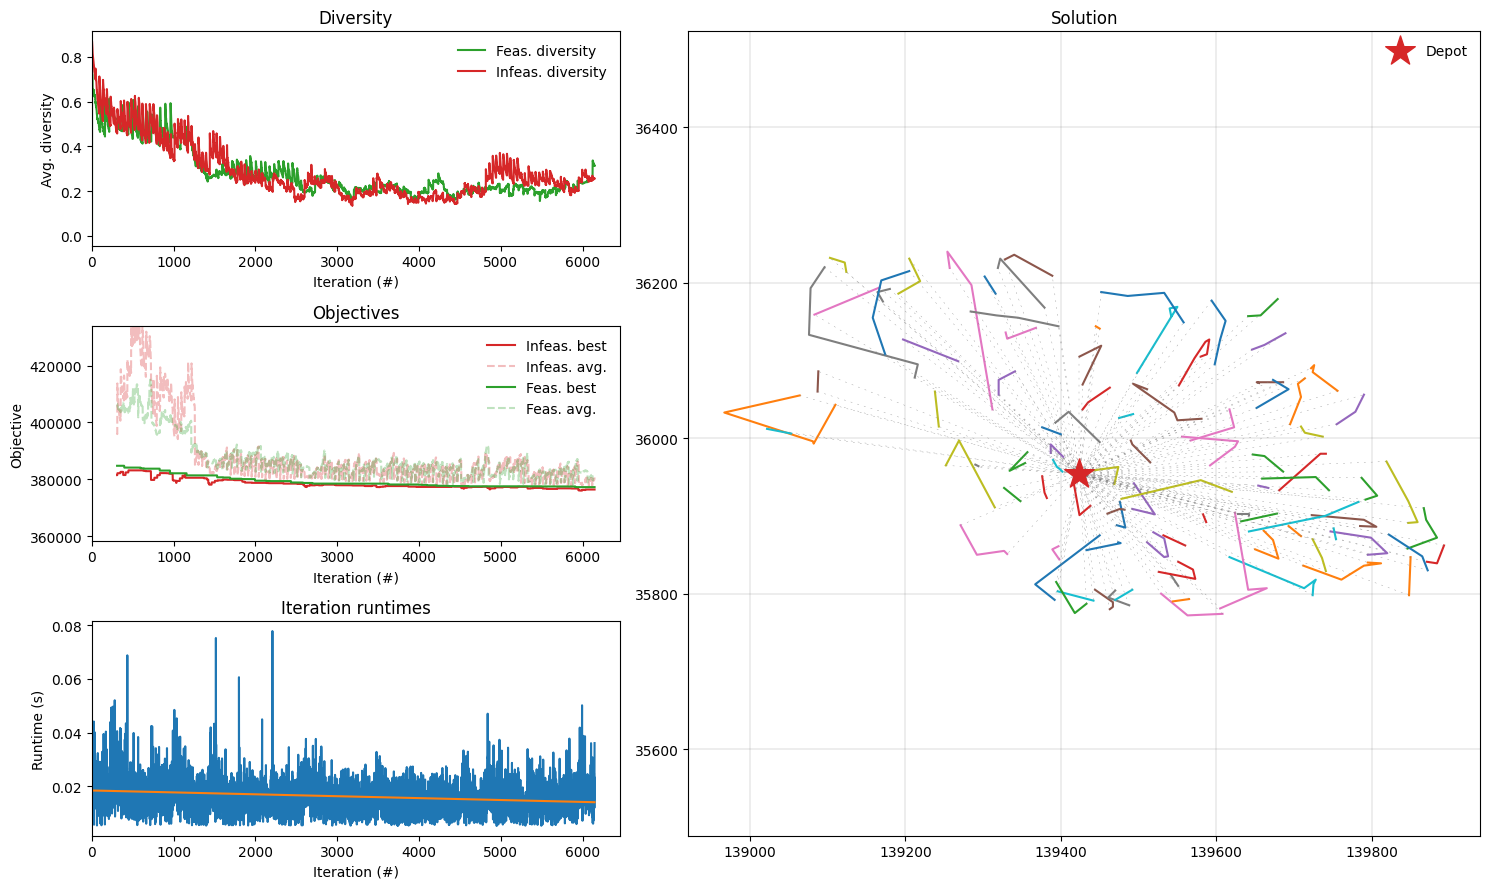

In [ ]:
#| hide
# pyvrp に変換して解く
MAX_INT = 1000000 #時間枠の最大値
NO_IMP = 1000     #改良しない回数
SEED = 123        #種

m = PyvrpModel()

depots = {} #location_index をキー，デポを値とした辞書
for v in model.vehicles:
    if v.start_index is not None:
        depots[v.start_index] = None
locations = []
indices = [] 
#depotsを追加
for d in depots.keys():
    depot_info = node_df.iloc[d,:]
    depot_location = ast.literal_eval(depot_info.location)
    depots[d] = m.add_depot(x= int(depot_location[0]*1000), y=int(depot_location[1]*1000), 
                            tw_early=0, tw_late = MAX_INT, name= f"depot({d})" )
    locations.append(depots[d])
    indices.append(d)

#vehiclesを追加
for v in model.vehicles:
    if v.time_window is None:
        early = 0
        late = MAX_INT 
    else:
        early = v.time_window[0]
        late = v.time_window[1]
        
    m.add_vehicle_type(num_available = 1, 
                       capacity= v.capacity[0],
                       depot = depots[v.start_index],
                       fixed_cost = v.costs.fixed,
                       tw_early = early,
                       tw_late = late,
                       max_duration = v.max_travel_time, 
                       name = f"vehicle({v.id})"
               )

for j in model.jobs:
    if j.time_windows is None:
        early = 0
        late = MAX_INT 
    else:
        #時間枠の大きい方を選択
        max_width = 0
        max_k = -1
        for k, (e,l) in enumerate(j.time_windows):
            if (l-e) > max_width:
                max_width = l-e
                max_k = k
        if max_k < 0:
            raise ValueError
        early = j.time_windows[max_k][0]
        late = j.time_windows[max_k][1]
    client = m.add_client(x= int(j.location[0]*1000), y= int(j.location[1]*1000), demand=j.delivery[0],   #pickup & delivery
                 service_duration= j.service, tw_early = early, tw_late = late, required = False, prize=10000, 
                 name = f"client({j.id})"
                )
    locations.append(client)
    indices.append(j.location_index)
#add edges using matrix    
durations = model.matrices["car"].durations
for frm,i in zip(locations,indices):
    for to,j in zip(locations,indices):
        m.add_edge(frm, to, distance=durations[i][j], duration=durations[i][j])


res = m.solve(stop=MaxRuntime(100), seed=SEED)
#res = m.solve(stop=MaxIterations(1000), seed=SEED)
#res  = m.solve(stop=NoImprovement(NO_IMP), seed=SEED)
print(res.cost(),len(res.best.get_routes()))

data= m.data()
fig = plt.figure(figsize=(15, 9))
plot_result(res, data, fig)
fig.tight_layout()

In [ ]:
for r in res.best.get_routes():
    print(r, r.duration())

298 191 46  4655
146 185 87 242  9056
19 5 264  4702
249 142 21 77 6 287  9589
82 106 293  8612
253 269 64 275  9617
238 236 290 208  8115
25 127 248  5823
278 109  6124
119 134 116  4633
29 296 27  6479
285 174  7568
245 13 130  8578
97 229 90  5108
57 43 288  4835
255 171 179 277  7100
44 80 117  6452
60 111 147  7879
14 259 131  7533
158 211 153 78  8848
172 126 36  6445
297 276 98 104  8268
180 159 177  6446
164 73 167  5590
188 252 51  6276
284 230 144  7190
274 122 52  7296
240 20 193  4626
143 39 102  7559
289 145 94 291 181  9951
139 48 214 50  8760
299 61 136  5870
56 120 124  8143
175 232  5056
194 213 178  4238
157 280  7161
3 63 205 1  8300
295 300 35  6216
155 96 108  7925
251 83 49  5870
9 55 192  5618
190 121 212 12 281  12196
133 4 84  5170
209 266 204  8759
219 110 30  7621
228 41 273 141 81  8516
54 200 138 202  8138
22 227 250 85 196  12004
8 89 223  7206
233 199 53 220  8462
123 270 118  4705
197 75 237 226 198  10398
286 173 239 148  10273
31 67 241  6558
176 45 68

In [ ]:
len(res.best.get_routes())

In [ ]:
#job_df.head()

In [ ]:
#node_df.head()

In [ ]:
#job_df.head()

In [ ]:
#shipment_df.head()

In [ ]:
#vehicle_df.head()

In [ ]:
#time_df.head()

In [ ]:
#break_df

In [ ]:
#| hide
# no ="02"
# node_df.to_csv(folder +"node"+no+".csv")
# job_df.to_csv(folder +"job"+no+".csv") 
# shipment_df.to_csv(folder +"shipment"+no+".csv") 
# vehicle_df.to_csv(folder +"vehicle"+no+".csv") 
# time_df.to_csv(folder+"time"+no+".csv")

In [ ]:
#| hide
# no ="06"
# node_df = pd.read_csv(folder +"node"+no+".csv")
# job_df = pd.read_csv(folder +"job"+no+".csv") 
# shipment_df = pd.read_csv(folder +"shipment"+no+".csv") 
# vehicle_df = pd.read_csv(folder +"vehicle"+no+".csv") 

In [ ]:
#| hide
# demand = pd.concat([job_df.pickup, job_df.delivery,shipment_df.amount],axis=0)
# demand = demand.apply(ast.literal_eval)
# max_demand = demand.max()[0] #第１要素が最もボトルネックになっていると仮定
# # total_demand =0
# # max_demand = 0
# # for i in demand:
# #     total_demand += i[0]
# #     max_demand = max(max_demand, i[0])
# #capacity = vehicle_df.capacity.apply(ast.literal_eval)
# #average_capacity = sum(capacity.sum())/len(capacity)
# #demand_ratio = np.array(demand.sum())/average_capacity #demand_ratio 

# # tw = pd.concat([job_df.time_windows, shipment_df.pickup_time_windows, shipment_df.delivery_time_windows],axis=0)
# # tw = tw.apply(ast.literal_eval)
# # tw_width =[]
# # for row in tw:
# #     for r in row:
# #         width = r[1]-r[0]
# #         tw_width.append(width)
# # tw_width = np.array(tw_width)
# priority = pd.concat([job_df.priority, shipment_df.priority],axis=0)
# max_priority = priority.max()

## ユーテリティ関数

### 時間変換関数 time_convert

引数： 
- sec: 秒数
- start: 開始時刻を表す文字列（年，月，日，時間，分，秒で，"2000-01-01 00:00:00"のような形式で入力する．）

返値：
- 開始時刻startからsec秒経過した時刻

In [ ]:
#| export
def time_convert(sec, start):
    """
    時間変換のユーテリティ関数
    """
    try:
        start = pd.to_datetime(start)
    except:
        pass
    seconds = int(sec)
    try:
        finish = start + dt.timedelta(seconds=seconds)
        return finish.strftime("%Y-%m-%d %H:%M")
    except TypeError:
        finish = (dt.datetime.combine(dt.date(2000,1,1), start) + dt.timedelta(seconds=seconds))
        return finish.strftime("%H:%M")

### time_convert関数の使用例

In [ ]:
time_convert(1000, "2000-01-01 00:00:00")

### ガントチャート生成関数

ルート情報をもとにガントチャートを生成する関数

引数：
- route_df_dic: キーをルート番号とし，ルートの情報を格納したデータフレームを値とした辞書 
- start: 開始時刻を表す文字列（年，月，日，時間，分，秒で，"2000-01-01 00:00:00"のような形式で入力する．）

返値：
- fig: plotlyの図オブジェク

In [ ]:
#| export
def gannt_for_vrp(route_df_dic, start="2000/01/01 00:00:00"):
    """
    ルートのガントチャートを生成する関数
    """
    L = []
    for v, route in route_df_dic.items():
        for row in route.itertuples():
            arrival_time = time_convert(row.arrival, start) #到着時刻
            after_wait_time =time_convert(row.arrival+row.waiting_time, start) #待ち終了時刻
            departure_time = time_convert(row.arrival+row.waiting_time+row.service, start) #出発時刻
    
            ar = arrival_time
            after_wait = after_wait_time
            dp = departure_time
    
            if row.type == "start":
                prev_name = "Start"
            elif row.type == "end":
                move = dict(Task= "Move", Start= st, Finish= ar, Resource=f"Vehicle{v}", 
                            labels = prev_name + " => " + "end")
                L.append(move)
                break
            else:
                move = dict(Task= "Move", Start=st, Finish= ar, Resource=f"Vehicle{v}", 
                            labels = prev_name + f" => {row.id}"  ) 
                L.append(move)
    
                #待ち
                wait = dict(Task= "Wait", Start= ar, Finish=after_wait, Resource=f"Vehicle{v}",labels =row.id)
                L.append(wait)
                #サービス
                if row.type =="break":
                    serve = dict(Task="Break", Start=after_wait, Finish=dp, Resource=f"Vehicle{v}",labels = row.id)
                else:
                    serve = dict(Task= "Service", Start=after_wait, Finish=dp, Resource=f"Vehicle{v}",labels = row.id)
                L.append(serve)
                prev_name = f"{row.id}"
            st = departure_time #以前の出発時刻を保存
    
    df = pd.DataFrame( L ) 
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Resource", color="Task", hover_name ="labels",
                     color_discrete_sequence=["red",  "blue", "goldenrod", "green", "magenta"])

    #from plotly.figure_factory import create_gantt
    #https://plotly.github.io/plotly.py-docs/generated/plotly.figure_factory.create_gantt.html
    #fig = create_gantt(df, index_col ="Resource")
    
    return fig

### gannt_for_vrp関数の使用例

In [ ]:
fig = gannt_for_vrp(route_df_dic, start= "2020/01/01 8:00" )
#plotly.offline.plot(fig);

### 時間枠の可視化関数 make_tw_fig_for_vrp

引数：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- start: 開始時刻を表す文字列（年，月，日，時間，分，秒で，"2000-01-01 00:00:00"のような形式で入力する．）

返値：
- fig: plotlyの図オブジェクト

In [ ]:
#| export
def make_tw_fig_for_vrp(job_df, shipment_df, start="2000/01/01 00:00:00"):
    """
    時間枠を可視化する関数
    """
    L = []
    for row in job_df.itertuples():
        tw_list = ast.literal_eval(row.time_windows)
        for i,tw in enumerate(tw_list):
            L.append(dict(Task=f"time window {i}", Start=time_convert(tw[0],start), Finish=time_convert(tw[1],start), Resource=row.name))
    
    for row in shipment_df.itertuples():
        tw_list = ast.literal_eval(row.pickup_time_windows)  
        for i,tw in enumerate(tw_list):
            L.append(dict(Task=f"pickup time window {i}", Start=time_convert(tw[0],start), Finish=time_convert(tw[1],start), Resource= row.pickup_point))
        tw_list = ast.literal_eval(row.delivery_time_windows)  
        for i,tw in enumerate(tw_list):
            L.append(dict(Task=f"delivery time window {i}", Start=time_convert(tw[0],start), Finish=time_convert(tw[1],start), Resource= row.delivery_point))
    df = pd.DataFrame( L ) 
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Resource", color="Task")
    return fig

### make_tw_fig_for_vrp関数の使用例

In [ ]:
job_df = pd.read_csv(folder+"job.csv", index_col=0)
shipment_df = pd.read_csv(folder+"shipment.csv", index_col=0)
fig = make_tw_fig_for_vrp(job_df, shipment_df, start= "2020/01/01 8:00")
#plotly.offline.plot(fig);

In [ ]:
#| hide_input
#Image("../figure/make_tw_fig.png")

## 地図描画

### ルートを追加する関数 add_route_for_vrp

引数：
- output_dic: 最適化の出力を保管した辞書
- map_style: 地図のスタイルを表す番号で 0,1,2のいずれかを入れる．これは，mapboxのスタイル "satellite-streets" , "open-street-map", "dark" に対応している．

返値：
- data: ルートの図オブジェクトのリスト

In [ ]:
#| export
def add_route_for_vrp(output_dic, map_style=0):
   
    line_color =["yellow", "black", "white" ]
    data = [] 
    for r in output_dic["routes"]:
        edge_trace_x, edge_trace_y = [], []
        for i, s in enumerate(r["steps"]):
            try:
                lon,lat = s["location"]
            except:
                pass
            if i==0:
                lat0, lon0 = lat, lon
                continue

            edge_trace_x += [lat0, lat, None]
            edge_trace_y += [lon0, lon, None]
            lat0, lon0 = lat, lon

        data.append(
            Scattermapbox(  # edge
                lat=edge_trace_x,
                lon=edge_trace_y,
                line=dict(width=2, color=line_color[ map_style ]),
                hoverinfo='none',
                mode='lines',
                name="vehicle:"+str(r["vehicle"])
            ))   
    return data

### 通過した道路を追加する関数 add_road_for_vrp

引数：
- output_dic: 最適化の出力を保管した辞書
- map_style: 地図のスタイルを表す番号で 0,1,2のいずれかを入れる．これは，mapboxのスタイル "satellite-streets" , "open-street-map", "dark" に対応している．

返値：
- data: ルート（通過道路）の図オブジェクトのリスト

In [ ]:
#| export
def add_road_for_vrp(output_dic, map_style=0):
    
    line_color =["yellow", "black", "white" ]
    data =[] 
    for i,r in enumerate(output_dic["routes"]):
        try: #道路の描画
            route = polyline.decode(output_dic["routes"][i]["geometry"])
            edge_trace_x, edge_trace_y = [], []
            for i, (lat,lon) in enumerate(route):
                if i==0:
                    lat0, lon0 = lat, lon
                    continue

                edge_trace_x += [lat0, lat, None]
                edge_trace_y += [lon0, lon, None]
                lat0, lon0 = lat, lon
        except: #失敗した場合には直線で描画
            for i, s in enumerate(r["steps"]):
                try:
                    lon,lat = s["location"]
                except:
                    pass
                if i==0:
                    lat0, lon0 = lat, lon
                    continue

                edge_trace_x += [lat0, lat, None]
                edge_trace_y += [lon0, lon, None]
                lat0, lon0 = lat, lon

        data.append(
            Scattermapbox(  # edge
                lat=edge_trace_x,
                lon=edge_trace_y,
                line=dict(width=3, color=line_color[ map_style ]),
                hoverinfo='none',
                mode='lines',
                name="vehicle"+str(r["vehicle"])
            ))    
    return data

### 描画関数 make_fig_for_vrp

引数：
- input_dic: 最適化への入力情報を保管した辞書
- output_dic: 最適化の出力を保管した辞書
- show_mode: 描画モードを表す文字列． ノードのみを表示させるとき "node"， ルートを直線で表示させるとき "route"， 道路情報を図に入れるとき "road" とする．
- map_style: 地図のスタイルを表す番号で 0,1,2のいずれかを入れる．これは，mapboxのスタイル "satellite-streets" , "open-street-map", "dark" に対応している．

返値：
- fig: plotlyの地図オブジェクト

In [ ]:
#| export
def make_fig_for_vrp(input_dic, output_dic, show_mode = "road", map_style=0):
    """
    図の表示
    """
    maps = ["satellite-streets" , "open-street-map", "dark"]
    
    #jobs 
    latitude, longitude, text = [], [], []
    max_demand = 0
    max_priority = 0
    for i,j in enumerate(input_dic["jobs"]):
        latitude.append( j["location"][1] )
        longitude.append( j["location"][0] )
        text.append(f"{i} : {j['description']}, pickup:delivery={j['pickup'][0]}:{j['delivery'][0]}, priority={j['priority']}")
        max_demand = max(max_demand, j["pickup"][0])
        max_demand = max(max_demand, j["delivery"][0])
        max_priority = max(max_priority, j["priority"])
    node_size =[]
    node_color =[]
    for j in input_dic["jobs"]:      
        node_size.append( 10*(j["pickup"][0]+j["delivery"][0])/(max_demand+1) + 5 )
        node_color.append( j["priority"]/(max_priority+1) )
        
    #vehicles
    latitude2, longitude2, text2 = [], [], []
    for j in input_dic["vehicles"]:
        if "start" in j:
            latitude2.append(j["start"][1])
            longitude2.append(j["start"][0])
            text2.append( f"{j['id']}:start")
        if "end" in j:
            latitude2.append(j["end"][1])
            longitude2.append(j["end"][0])
            text2.append( str(j["id"])+":end")
    
    #shipments
    latitude3, longitude3, text3 = [], [], []
    edge_trace_x, edge_trace_y = [], []
    if "shipments" in input_dic:
        for j in input_dic["shipments"]:
            latitude3.append( j['pickup']["location"][1] )
            longitude3.append( j['pickup']["location"][0] )
            text3.append(f"Pickup : amount={j['amount']}")
            
            latitude3.append( j['delivery']["location"][1] )
            longitude3.append( j['delivery']["location"][0] )
            text3.append(f"Delivery")
            
            edge_trace_x += [j['pickup']["location"][1], j['delivery']["location"][1], None]
            edge_trace_y += [j['pickup']["location"][0], j['delivery']["location"][0], None]
     
    data =[]
    #ルートデータ追加
    if show_mode == "road": #道路地図を描画
        data.extend( add_road_for_vrp(output_dic, map_style) )

    elif show_mode =="route": #ルートを直線で描画
        data.extend( add_route_for_vrp(output_dic, map_style) ) 
        
    data.extend([
        Scattermapbox(  # Jobs
            lat=latitude,
            lon=longitude,
            mode='markers',
            marker=dict(
                size=node_size, color=node_color, opacity=0.8
            ),
            #hoverinfo= "text",
            #hovertext=text,
            text = text, 
            name="Jobs"
        ),
        Scattermapbox(  # Vehicles
            lat=latitude2,
            lon=longitude2,
            mode='markers',
            marker=dict(
                size=20, color="blue", opacity=0.8
            ),
            #text=text2,
            name="Depot(s)"
        ),
        Scattermapbox(  # shipment arc 
            lat= edge_trace_x,
            lon= edge_trace_y,
            line=dict(width=5, color='orange'),
            hoverinfo='none',
            mode='lines',
            name="Shipment Arcs"
        ),
        Scattermapbox(  # shipment node
            lat=latitude3,
            lon=longitude3,
            mode='markers',
            marker=dict(
                size=30, color="red", opacity=0.8
            ),
            #hoverinfo= "text",
            #hovertext=text3,
            text = text3, 
            name="Shipments"
        ),
    ])
        
    layout = Layout(
        title ="点の大きさ：需要量  点の色：優先度 (Size:Demand Color:Priority)",
        showlegend=True,
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=latitude2[0],
                lon=longitude2[0]
            ),
            pitch=0,
            zoom=10,
            style= maps[ map_style ]
        ),
    )
    fig = Figure(data=data, layout=layout)
    # resize fig
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        paper_bgcolor="LightSteelBlue",
    )
    return fig

### make_fig_for_vrp関数の使用例

In [ ]:
#
with open('test1.json', 'r') as example1_in:
    input_dic = json.load(example1_in)
with open('output1.json', 'r') as f:
    output_dic = json.load(f)        
fig = make_fig_for_vrp(input_dic, output_dic, show_mode="route", map_style = 2 )
#plotly.offline.plot(fig);

In [ ]:
#| hide_input
Image("../figure/make_fig_for_vrp.png", width=500)

### 詳細ルートを描画する関数 make_detailed_route

引数：
- output_dic: 最適化の出力を保管した辞書
- route_df_dic: ルートのデータフレームを保持する辞書
- route_id: 表示したいルートの番号
- matrix: 移動時間行列を与えるときTrue（既定値はFalse）
- map_style: 地図のスタイルを表す番号で 0,1,2のいずれかを入れる．これは，mapboxのスタイル "satellite-streets" , "open-street-map", "dark" に対応している．
- straight: Uターンを抑制するためのフラグ；Trueのとき直線を優先する．FalseのときはUターンを許す．既定値は Noneで，Uターンと移動時間の兼ね合いを考えて自動選択する．
- host: ホスト名；既定値は "localhost"

返値：
- fig: plotlyの地図オブジェクト


In [ ]:
#| export
def make_detailed_route(input_dic, output_dic, route_df_dic, route_id=0, matrix=False, 
                        map_style=0, straight = None, host="localhost"):
    """
    詳細ルートの図を描画する関数
    """
    ROUTE = []
    latitude, longitude = [], [] 
    for node in output_dic["routes"][route_id]["steps"]:
        #print(node["location"])
        if "location" in node: #最後がbreakでパス型だと位置がないため
            ROUTE.append( node["location"] )
            longitude.append(node["location"][0])
            latitude.append(node["location"][1])
            
    vid = output_dic["routes"][route_id]["vehicle"]
    vehicle = input_dic["vehicles"][vid]
    latitude2, longitude2, text2 = [], [], []
    if "start" in vehicle:
        latitude2.append(vehicle["start"][1])
        longitude2.append(vehicle["start"][0])
        text2.append( f"{vehicle['id']}:start")
        
    if "end" in vehicle:
        latitude2.append(vehicle["end"][1])
        longitude2.append(vehicle["end"][0])
        text2.append( str(vehicle["id"])+":end")

    if matrix == False: #詳細ルート準備
        
        if straight == True:
            straight_flag = "true"
        elif  straight == False:
            straight_flag = "false"
        elif pd.isnull(straight):
            straight_flag = "default"
        else:
            print("Unknown straight option")
            return -1,-1,-1

        route_str =""
        for (i,j) in ROUTE:
            route_str += str(i)+","+str(j)+";"
        try:
            #print(f'http://{host}:5000/route/v1/driving/'+route_str[:-1]+f"?annotations=distance,duration&overview=full&continue_straight={straight_flag}")
            response = requests.get(f'http://{host}:5000/route/v1/driving/'+route_str[:-1]+f"?annotations=distance,duration&overview=full&continue_straight={straight_flag}")
            result = response.json()
            route = polyline.decode(result["routes"][0]["geometry"])
        except:
            print("route draw error")
            matrix = True #失敗した場合には，直線で描画
    if matrix == True: 
        route = []
        for (lon,lat) in ROUTE:
            route.append( (lat,lon) )
        
    maps = ["satellite-streets" , "open-street-map", "dark"]
    line_color =["yellow", "black", "white" ]
    node_color =["blue", "red", "yellow" ]
    
    edge_trace_x, edge_trace_y = [], []
    for i, (lat,lon) in enumerate(route):
        if i==0:
            lat0, lon0 = lat, lon
            continue
        edge_trace_x += [lat0, lat, None]
        edge_trace_y += [lon0, lon, None]
        lat0, lon0 = lat, lon

    data=[   
        Scattermapbox(  # node
            lat=latitude,
            lon=longitude,
            mode='markers',
            marker=dict(
                size=30, color=node_color[map_style], opacity= 0.9 
            ),
            #hoverinfo= "text",
            #hovertext=text,
            #text = route_df_dic[route_id].name, 
            name="Nodes"
        ),
    ]
    data.append(
            Scattermapbox(  # Vehicles
            lat=latitude2,
            lon=longitude2,
            mode='markers',
            marker=dict(
                size=40, color="blue", opacity=0.8
            ),
            name="Depot(s)"
        ))
        
    data.append(
        Scattermapbox(  # edge
            lat=edge_trace_x,
            lon=edge_trace_y,
            line=dict(width=5, color=line_color[ map_style ]),
            hoverinfo='none',
            mode='lines'
        ))    
    layout = Layout(
        title ="ルート詳細 Datailed Route",
        showlegend=True,
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=latitude[0],
                lon=longitude[0]
            ),
            pitch=0,
            zoom=10,
            style= maps[ map_style ]
        ),
    )
    fig = Figure(data=data, layout=layout)
    # resize fig
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        paper_bgcolor="LightSteelBlue",
    )
    return fig

### make_detailed_route関数の使用例

In [ ]:
#
fig = make_detailed_route(input_dic, output_dic, route_df_dic, route_id=0, 
                          matrix=False, map_style=1, straight = False, host=host)
#plotly.offline.plot(fig);

In [ ]:
#| hide_input
Image("../figure/make_detailed_route.png", width=500)

### 実行例

In [ ]:
%%time
#問題例読み込み

matrix = True #時間行列を用いる場合 True
map_style = 1

no = "01"
node_df = pd.read_csv(folder+"node"+no+".csv", index_col=0)
job_df = pd.read_csv(folder+"job"+no+".csv", index_col=0)
shipment_df = pd.read_csv(folder+"shipment"+no+".csv", index_col=0)
vehicle_df = pd.read_csv(folder+"vehicle"+no+".csv", index_col=0)
time_df = pd.read_csv(folder+"time"+no+".csv", index_col=0)
break_df = pd.read_csv(folder + "break.csv", index_col=0)

#モデル生成
if matrix:
    model = build_model_for_vrp(job_df, shipment_df, vehicle_df, break_df, time_df)
else:
    model = build_model_for_vrp(job_df, shipment_df,vehicle_df, break_df)

#new_model = Model(**model)
#if matrix:
#    model.matrices ={"car": Matrix(durations = model.matrix) }

#最適化
input_dic, output_dic, error = optimize_vrp(model, matrix=matrix, explore=5, cloud=False, osrm=True, host=host)

if error != "":
    print(error) 
else:
    pass
    # if matrix:
    #     fig = make_fig_for_vrp(input_dic, output_dic, show_mode="route", map_style=map_style)
    # else:
    #     fig = make_fig_for_vrp(input_dic, output_dic, show_mode="road", map_style=map_style)
    # plotly.offline.plot(fig);

    # route_df_dic, unassigned_job_df, unassigned_shipment_df = make_route_for_vrp(job_df, shipment_df, 
    #                                                                              vehicle_df, break_df, output_dic)
    summary_df, route_summary_df, unassigned_df, route_df_dic = make_solution(output_dic)
    # fig = gannt_for_vrp(route_df_dic, start= "2020/01/01 8:00" )
    # plotly.offline.plot(fig);

    # fig = make_tw_fig_for_vrp(job_df, shipment_df, start= "2020/01/01 8:00")
    # plotly.offline.plot(fig);

print("cost=", output_dic["summary"]["cost"])

In [ ]:
#| hide
#fig = make_detailed_route(input_dic, output_dic, route_df_dic, route_id=0, matrix=matrix, map_style=0, straight = None)
#fig = gannt_for_vrp(route_df_dic, start= "2020/01/01 8:00" )
#plotly.offline.plot(fig)

In [ ]:
#| hide_input
Image("../figure/metro-ex10-1.png", width=500)

In [ ]:
#| hide_input
Image("../figure/metro-ex10-2.png", width=500)

In [ ]:
#| hide_input
Image("../figure/metro-ex10-3.png", width=500)

### 例題

Webシステムで現在使用している例題を以下に示す（Webシステムで番号を選択すると例題がロードされる）． 

0.  容量制約
1.  広い時間枠
2.  狭い時間枠
3.  複数の時間枠
4. 複数のデポ（運搬車の発着地）
5. パス型のルート（始点か終点のいずれかがなし）
6. （デポ以外での）積み込み積み降ろし
7. 休憩（11時から2時の間に1時間昼食休憩を入れる．）
8. スキル（入庫不可条件など）
9. 優先度（顧客を訪問しない場合のペナルティ）
10. 大規模問題例


## ExcelとStreamlitによる簡易配送計画インターフェイス

### テンプレート生成関数のための準備関数群 

In [ ]:
#| export
def make_job_excel(wb, n_job=100, num_dim = 3, num_tw = 3, num_skill = 3, date_flag = True):
    #wb = Workbook()
    ws = wb.create_sheet(title="ジョブ")
    tw_list =[]
    for i in range(num_tw):
        tw_list.extend( [f"最早時刻{i+1}", f"最遅時刻{i+1}" ] )

    ws.append(["名称","作業時間（分）","経度（小数)","緯度(小数)"]+
              tw_list + 
              [f"積み込み量{i+1}" for i in range(num_dim)]+
              [f"積み降ろし量{i+1}" for i in range(num_dim)]+
              [f"スキル{i+1}（0か1)" for i in range(num_skill)]+["優先度（1..100)"]
              )
    #時間フォーマット
    for i in range(n_job):
        for j in range(num_tw*2):
            if date_flag:
                ws.cell(2+i,5+j).number_format = 'yyyy/m/d\\ h:mm;@'
            else:
                ws.cell(2+i,5+j).number_format = 'h:mm;@'

    #作業時間バリデーション
    dv = DataValidation(type="whole", allow_blank=False)
    ws.add_data_validation(dv)
    dv.add('B2:B1048576')  
    
    #緯度経度バリデーション
    dv = DataValidation(type="decimal", allow_blank=False)
    ws.add_data_validation(dv)
    dv.add('C2:D1048576')  
    
    #日付・時刻バリデーション
    dv = DataValidation(type="time") 
    ws.add_data_validation(dv)
    c1 = ws.cell(2,4+2*num_tw)
    dv.add(f'E2:{c1.column_letter}1048576')   
    #積み込み・積み降ろし
    dv = DataValidation(type="whole",
                    operator="greaterThanOrEqual",
                    formula1=0)
    ws.add_data_validation(dv)
    c2 = ws.cell(2,4+2*num_tw+1) 
    c3 = ws.cell(2,4+2*num_tw+2*num_dim) 
    dv.add(f'{c2.column_letter}2:{c3.column_letter}1048576') 
    #スキル
    dv = DataValidation(type="whole",
                    operator="between",
                    formula1=0,
                    formula2=1)
    ws.add_data_validation(dv)
    c4 = ws.cell(2,4+2*num_tw+2*num_dim +1)
    c5 = ws.cell(2,4+2*num_tw+2*num_dim +num_skill)
    dv.add(f'{c4.column_letter}2:{c5.column_letter}1048576') 
    #優先度
    dv = DataValidation(type="whole",
                    operator="between",
                    formula1=1,
                    formula2=100)
    ws.add_data_validation(dv)
    c6 = ws.cell(2,4+2*num_tw+2*num_dim +num_skill+1)
    dv.add(f'{c6.column_letter}2:{c6.column_letter}1048576') 
    
    #コメント
    ws.cell(1,1).comment = Comment("ジョブ（顧客）の名称（住所などの付加情報）", "logopt")
    ws.cell(1,2).comment = Comment("作業時間（分）", "logopt")
    ws.cell(1,3).comment = Comment("ジョブの経度．形式例 140.268． Google Mapで右クリック", "logopt")
    ws.cell(1,4).comment = Comment("ジョブの緯度．形式例 35.6983． Google Mapで右クリック", "logopt")
    col = 5
    for i in range(2*num_tw):
        ws.cell(1,col+i).comment = Comment("ジョブの時間枠（日付時刻型，時刻型）", "logopt")
    col += 2* num_tw
    for i in range(2*num_dim):
        ws.cell(1,col+i).comment = Comment("ジョブの積み込み・積み降ろし量を次元別（容量とか重量など）", "logopt")
    col += 2*num_dim
    for i in range(num_skill):
        ws.cell(1,col+i).comment = Comment("ジョブを遂行にスキルが必要な場合には1，必要ない場合には0", "logopt")
    col += num_skill
    ws.cell(1,col).comment = Comment("ジョブの優先度（1から100の整数）", "logopt")
    return wb

In [ ]:
wb = Workbook()
ws = wb.active
wb.remove(ws)
wb = make_job_excel(wb, n_job=100, num_dim = 2, num_tw = 2, num_skill = 2, date_flag = False)
wb.save("metro-job.xlsx")

In [ ]:
#| export 
def make_shipment_excel(wb, n_shipment=100, num_dim = 3, num_tw = 3, num_skill = 3, date_flag = True):
    ws = wb.create_sheet(title="輸送")
    pick_tw_list =[]
    for i in range(num_tw):
        pick_tw_list.extend( [f"最早時刻{i+1}（積み込み）", f"最遅時刻{i+1}（積み込み）" ] )
    deli_tw_list =[]
    for i in range(num_tw):
        deli_tw_list.extend( [f"最早時刻{i+1}（積み降ろし）", f"最遅時刻{i+1}（積み降ろし）" ] )
        
    ws.append([""]*num_dim +["積み込み"]+[""]*(3+num_tw*2) +["積み降ろし"]+[""]*(3+num_tw*2) )
    ws.append([f"輸送量{i+1}" for i in range(num_dim)]+ 
              ["名称（積み込み）","作業時間（（積み込み））","経度（積み込み）","緯度（積み込み）"]+
              pick_tw_list + 
              ["名称（積み降ろし）","作業時間（（積み降ろし））","経度（積み降ろし）","緯度（積み降ろし）"]+
              deli_tw_list + 
              [f"スキル{i+1}（0か1)" for i in range(num_skill)]+["優先度(1..100)"]
              )
    #1行目のマージ
    ws.merge_cells(start_row=1, start_column=num_dim+1, end_row=1, end_column=num_dim+4+num_tw*2)
    ws.merge_cells(start_row=1, start_column=num_dim+5+num_tw*2, end_row=1, end_column=num_dim+8+num_tw*4)

    #時間フォーマット（積み込み）
    for i in range(n_shipment):
        for j in range(num_tw*2):
            if date_flag:
                ws.cell(3+i, num_dim+5+j).number_format = 'yyyy/m/d\\ h:mm;@'
            else:
                ws.cell(3+i,num_dim+5+j).number_format = 'h:mm;@'
    #時間フォーマット（積み降ろし）
    for i in range(n_shipment):
        for j in range(num_tw*2):
            if date_flag:
                ws.cell(3+i, num_dim+9+num_tw*2+j).number_format = 'yyyy/m/d\\ h:mm;@'
            else:
                ws.cell(3+i,num_dim+9+num_tw*2+j).number_format = 'h:mm;@'
                
    #輸送量バリデーション
    dv = DataValidation(type="whole", allow_blank=False)
    ws.add_data_validation(dv)
    c1 = ws.cell(2, num_dim)
    dv.add(f'A3:{c1.column_letter}1048576')  
    
    #作業時間
    c1 = ws.cell(2, num_dim+2)
    dv.add(f'{c1.column_letter}3:{c1.column_letter}1048576')      
    c1 = ws.cell(2, num_dim+4+2*num_tw+2)
    dv.add(f'{c1.column_letter}3:{c1.column_letter}1048576')  
    
    #緯度経度バリデーション
    dv = DataValidation(type="decimal", allow_blank=False)
    ws.add_data_validation(dv)
    c1 = ws.cell(2, num_dim+3)
    c2 = ws.cell(2, num_dim+4)        
    dv.add(f'{c1.column_letter}3:{c2.column_letter}1048576')  
    c1 = ws.cell(2, num_dim+4+2*num_tw+3)
    c2 = ws.cell(2, num_dim+4+2*num_tw+4)
    dv.add(f'{c1.column_letter}3:{c2.column_letter}1048576')  
        
    #日付・時刻バリデーション
    dv = DataValidation(type="time") 
    ws.add_data_validation(dv)
    c1 = ws.cell(2,num_dim+5)
    c2 = ws.cell(2,num_dim+4+2*num_tw)
    dv.add(f'{c1.column_letter}3:{c2.column_letter}1048576')   
    c1 = ws.cell(2,num_dim+4+2*num_tw+5)
    c2 = ws.cell(2,num_dim+4+4*num_tw+4)
    dv.add(f'{c1.column_letter}3:{c2.column_letter}1048576')    

    #スキル
    dv = DataValidation(type="whole",
                    operator="between",
                    formula1=0,
                    formula2=1)
    ws.add_data_validation(dv)
    c4 = ws.cell(2,8+4*num_tw+num_dim +1)
    c5 = ws.cell(2,8+4*num_tw+num_dim +num_skill)
    dv.add(f'{c4.column_letter}3:{c5.column_letter}1048576') 
    
    #優先度
    dv = DataValidation(type="whole",
                    operator="between",
                    formula1=1,
                    formula2=100)
    ws.add_data_validation(dv)
    c6 = ws.cell(2,8+4*num_tw+num_dim +num_skill+1)
    dv.add(f'{c6.column_letter}3:{c6.column_letter}1048576') 

    #コメント
    col = 1
    for i in range(num_dim):
        ws.cell(2,col+i).comment = Comment("輸送の荷量を次元別（容量とか重量など）", "logopt")
    col += num_dim
    ws.cell(2,col).comment = Comment("積み込み地点の名称（住所などの付加情報）", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("作業時間（分）", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("積み込み地点の経度．形式例 140.268． Google Mapで右クリック", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("積み込み地点の緯度．形式例 35.6983． Google Mapで右クリック", "logopt")
    col +=1
    for i in range(2*num_tw):
        ws.cell(2,col+i).comment = Comment("積み込みの時間枠（日付時刻型，時刻型）", "logopt")
    col += 2* num_tw
    
    ws.cell(2,col).comment = Comment("積み降ろし地点の名称（住所などの付加情報）", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("作業時間（分）", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("積み降ろし地点の経度．形式例 140.268． Google Mapで右クリック", "logopt")
    col +=1
    ws.cell(2,col).comment = Comment("積み降ろし地点の緯度．形式例 35.6983． Google Mapで右クリック", "logopt")
    col +=1
    for i in range(2*num_tw):
        ws.cell(2,col+i).comment = Comment("積み降ろしの時間枠（日付時刻型，時刻型）", "logopt")
    col += 2* num_tw
    for i in range(num_skill):
        ws.cell(2,col+i).comment = Comment("ジョブを遂行にスキルが必要な場合には1，必要ない場合には0", "logopt")
    col += num_skill
    ws.cell(2,col).comment = Comment("ジョブの優先度（1から100の整数）", "logopt")
    return wb

In [ ]:
wb = Workbook()
wb = make_shipment_excel(wb, n_shipment=100, num_dim = 1, num_tw = 1, num_skill = 1, date_flag = True)
wb.save("metro-shipment.xlsx")

In [ ]:
#| export 
def make_vehicle_excel(wb, n_vehicle=100, num_dim = 3, num_skill = 3, num_break = 2, date_flag = True):
    ws = wb.create_sheet(title="運搬車")
    ws.append(["名称", "出発経度（小数）", "出発緯度（小数）", "到着経度（小数）", "到着緯度（小数）", "最早時刻", "最遅時刻"]+
              [f"積載量上限{i+1}" for i in range(num_dim)] + 
              [f"スキル{i+1}（0か1)" for i in range(num_skill)]+
              [f"休憩{i+1}（0か1)" for i in range(num_break)]
              )
    #時間フォーマット
    for i in range(n_vehicle):
        for j in range(2):
            if date_flag:
                ws.cell(2+i, 6+j).number_format = 'yyyy/m/d\\ h:mm;@'
            else:
                ws.cell(2+i,6+j).number_format = 'h:mm;@'
                
    #緯度経度バリデーション
    dv_latlng = DataValidation(type="decimal", allow_blank=True)
    ws.add_data_validation(dv_latlng)
    dv_latlng.add('B2:E1048576')   
    
    #日付・時刻バリデーション
    dv = DataValidation(type="time") 
    ws.add_data_validation(dv)
    dv.add('F2:G1048576')   
    
    #積載量バリデーション
    dv_load = DataValidation(type="whole",
                    operator="greaterThan",
                    formula1=0)
    ws.add_data_validation(dv_load)
    c1 = ws.cell(2, 7+num_dim)
    dv_load.add(f"H2:{c1.column_letter}1048576")
    #スキル，休憩バリデーション
    dv_other = DataValidation(type="whole",
                    operator="between",
                    formula1=0,
                    formula2=1)
    ws.add_data_validation(dv_other)
    c2 = ws.cell(2, 7+num_dim+1) #スキルの先頭
    c3 = ws.cell(2, 7+num_dim + num_skill + num_break) #休憩の終わり
    dv_other.add(f"{c2.column_letter}2:{c3.column_letter}1048576")

    
    #コメント
    ws.cell(1,1).comment = Comment("運搬車の名称（ドライバーなどの付加情報）", "logopt")
    ws.cell(1,2).comment = Comment("発地の経度．形式例 140.268． Google Mapで右クリック", "logopt")
    ws.cell(1,3).comment = Comment("発地の緯度．形式例 35.6983． Google Mapで右クリック", "logopt")
    ws.cell(1,4).comment = Comment("着地の経度．形式例 140.268． Google Mapで右クリック", "logopt")
    ws.cell(1,5).comment = Comment("着地の緯度．形式例 35.6983． Google Mapで右クリック", "logopt")
    ws.cell(1,6).comment = Comment("運搬車の最早開始時刻（日付時刻型，時刻型）", "logopt")
    ws.cell(1,7).comment = Comment("運搬車の最遅終了時刻（日付時刻型，時刻型）", "logopt")
    col = 8
    for i in range(num_dim):
        ws.cell(1,col+i).comment = Comment("運搬車の積載量上限（正数）を次元別（容量とか重量など）", "logopt")
    col += num_dim
    for i in range(num_skill):
        ws.cell(1,col+i).comment = Comment("運搬車（ドライバー）がスキルをもつ場合には1，ない場合には0", "logopt")
    col += num_skill
    for i in range(num_break):
        ws.cell(1,col).comment = Comment("運搬車（ドライバー）に休憩を指定する場合には1，そうでない場合には0", "logopt")
    
    return wb

In [ ]:
wb = Workbook()
wb = make_vehicle_excel(wb, n_vehicle=100, num_dim = 3, num_skill = 3, num_break = 2, date_flag = True)
wb.save("metro-vehicle.xlsx")

In [ ]:
#| export 
def make_break_excel(wb, num_break = 2, date_flag = False):
    ws = wb.create_sheet(title="休憩")
    ws.append(["名称", "最早時刻", "最遅時刻", "休憩時間（分）"])
    for i in range(num_break):
        ws.append([f"休憩{i+1}"])
    #時間フォーマット
    for i in range(num_break):
        for j in range(2):
            if date_flag:
                ws.cell(2+i, 2+j).number_format = 'yyyy/m/d\\ h:mm;@'
            else:
                ws.cell(2+i,2+j).number_format = 'h:mm;@'
    #日付・時刻バリデーション
    dv = DataValidation(type="time") 
    ws.add_data_validation(dv)
    dv.add('B2:C1048576')  
    
    #作業時間バリデーション
    dv = DataValidation(type="whole", allow_blank=False)
    ws.add_data_validation(dv)
    dv.add('D2:D1048576')  
    
    #コメント
    ws.cell(1,1).comment = Comment("休憩の名称（例：昼食休憩）", "logopt")
    ws.cell(1,2).comment = Comment("休憩の最早開始時刻（日付時刻型，時刻型）", "logopt")
    ws.cell(1,3).comment = Comment("休憩の最遅終了時刻（日付時刻型，時刻型）", "logopt")
    ws.cell(1,4).comment = Comment("休憩時間（分）", "logopt")
    return wb

In [ ]:
wb = Workbook()
ws = wb.active
wb.remove(ws)
wb = make_break_excel(wb, num_break = 1, date_flag = True)
wb.save("metro-break.xlsx")

In [ ]:
#| hide
# wb = load_workbook("metro-break.xlsx")
# ws = wb.active
# for row in ws.rows:
#     for cell in row:
#         print(cell.value)
# time_delta(ws.cell(2,3).value, dt.datetime(2020,1,1))

### Excelデータを生成する関数 create_excel_for_metro

引数：
- n_job: ジョブ数； 既定値は $100$ 
- n_shipment: 輸送数；　既定値は $100$ 
- n_vehicle: 運搬車数； 既定値は $100$ 
- num_dim: 積載重量の次元数; 既定値は $1$ 
- num_tw: 時間枠の数; 既定値は $1$ 
- num_skill: スキル数; 既定値は $1$ 
- num_break: 休憩数; 既定値は $1$ 
- date_flag: 時間入力を日付時刻型にする場合 True（既定値）， 時刻型にする場合 False（既定値はFalse)

返値：

- OpenPyXLのWorkbookオブジェクト；以下のシートをもつ．
  - ジョブ：列数は 4+num_tw * 2+num_dim * 2+num_skill+1 であり，既定値は $10$ 
  - 輸送: 列数は 8+num_tw*4+num_dim+num_skill+1 であり，既定値は $15$ 
  - 運搬車: 列数は 8+num_skill+num_break であり，既定値は $10$ 
  - 休憩: 列数は 4


In [ ]:
#| export
def create_excel_for_metro(n_job=100, n_shipment=100, n_vehicle=100, num_dim = 1, num_tw = 1, num_skill = 1, num_break=1, date_flag = False):
    
    wb = Workbook()
    ws = wb.active
    wb.remove(ws)
    wb = make_job_excel(wb, n_job, num_dim, num_tw, num_skill, date_flag)
    wb = make_shipment_excel(wb, n_shipment, num_dim, num_tw, num_skill, date_flag)        
    wb = make_vehicle_excel(wb, n_vehicle, num_dim, num_skill, num_break, date_flag)
    wb = make_break_excel(wb, num_break, date_flag)
    
    return wb

In [ ]:
wb = create_excel_for_metro(n_job=100, n_shipment=100, n_vehicle=100, num_dim = 2, num_tw = 2, num_skill = 2, num_break=1, date_flag = False)
wb.save("metro.xlsx")

### Excelブックからデータフレームを読み込む関数 read_dfs_from_excel

引数
- wb: Excel Workbook


返値：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム
- break_df: 休憩データフレーム


In [ ]:
#| export
def read_dfs_from_excel(wb):
    #job 
    data = wb["ジョブ"].values
    cols = next(data)[:]
    data = list(data)
    job_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    #shipment
    data = wb["輸送"].values
    next(data) #1行跳ばす
    cols = next(data)[:]
    data = list(data)
    shipment_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    #vehicle
    data = wb["運搬車"].values
    cols = next(data)[:]
    data = list(data)
    vehicle_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    #break
    data = wb["休憩"].values
    cols = next(data)[:]
    data = list(data)
    break_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    
    return job_df, shipment_df, vehicle_df, break_df

### Excelブックから移動時間データフレームを読み込む関数 read_time_from_excel

引数
- wb: Excel Workbook

返値：
- time_df: 移動時間データフレーム

In [ ]:
#| export
def read_time_from_excel(wb):
    #job 
    data = wb["移動時間"].values
    cols = next(data)[:]
    data = list(data)
    time_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    return time_df

### make_table_for_metro関数の準備関数 compute_table_sub

移動時間の可視化でも用いる．

In [ ]:
#| export
def compute_table_sub(job_df, shipment_df, vehicle_df, break_df, num_dim=1, 
                      num_tw=1, num_skill=1, num_break=1, toll=True, host="localhost"):
    #ユニークな経度・緯度の情報を抽出
    location_index ={}
    idx = 0
    for row in job_df.itertuples():
        lng = row[3]
        lat = row[4]
        if (lng,lat) not in location_index:
            location_index[(lng,lat)] = idx
            idx+=1
    for row in shipment_df.itertuples():
        lng = row[3+num_dim]
        lat = row[4+num_dim]
        if (lng,lat) not in location_index:
            location_index[(lng,lat)] = idx
            idx+=1
        col = 4+num_dim+2*num_tw + 3
        lng = row[col]
        lat = row[col+1]
        if (lng,lat) not in location_index:
            location_index[(lng,lat)] = idx
            idx+=1
    for row in vehicle_df.itertuples():
        lng = row[2]
        lat = row[3]
        if pd.isnull(lng) or pd.isnull(lat):
            pass
        else:
            if (lng,lat) not in location_index:
                location_index[(lng,lat)] = idx
                idx+=1
        lng = row[4]
        lat = row[5]
        if pd.isnull(lng) or pd.isnull(lat):
            pass
        else:
            if (lng,lat) not in location_index:
                location_index[(lng,lat)] = idx
                idx+=1
    #点のデータフレーム生成，時間計算
    idx_list, lng_list, lat_list = [],[],[]
    for (lng,lat) in location_index:
        idx_list.append( location_index[(lng,lat)] )
        lng_list.append( lng )
        lat_list.append( lat )
    cust_df = pd.DataFrame({"name": idx_list, "lat": lat_list, "lon": lng_list })
    durations,  distances, node_df = compute_durations(cust_df, toll=toll, host= host ) #coreで移動時間・移動距離を計算
    
    return durations,  distances, node_df, location_index

### 移動時間・距離のデータを生成する関数 make_table_for_metro

ジョブ，輸送，運搬車の経度・緯度情報をもとに，地点データを抽出し，ユニークなインデックスをもつ地点シートを追加する．

地点間の移動時間をOSRMで計算し， 移動時間データを生成し，移動時間シートに追加する．

さらに，ジョブ，輸送，運搬車に，対応する地点のインデックス情報を追加する．

引数
- wb: ExcelのWorkBook
- num_dim: 積載重量の次元数; 既定値は $1$ 
- num_tw: 時間枠の数; 既定値は $1$ 
- num_skill: スキル数; 既定値は $1$ 
- num_break: 休憩数; 既定値は $1$ 
- toll: 高速道路を使う場合 True（既定値）

返値
- wb: データを更新したExcelのWorkBook
- durations: 移動時間行列（単位は秒）
- distances: 距離行列（単位はm）


In [ ]:
#| export 
def make_table_for_metro(wb, num_dim=1, num_tw=1, num_skill=1, num_break=1, toll=True, host="localhost"):

    job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
    
    durations,  distances, node_df, location_index = compute_table_sub(job_df, shipment_df, vehicle_df, 
                                                                       break_df, num_dim, num_tw, num_skill, 
                                                                       num_break, toll, host)
    
    #移動時間データフレーム生成
    time_df = make_time_df(node_df, durations, distances)
    time_df = time_df[ ["from_node", "to_node", "time", "distance"] ]
    #シート生成・書き出し
    ws = wb.create_sheet(title="地点")
    for r in dataframe_to_rows(node_df, index=False, header=True):
        ws.append(r)
    ws = wb.create_sheet(title="移動時間")
    for r in dataframe_to_rows(time_df, index=False, header=True):
        ws.append(r)
    #基本データにlocation_index追加    
    ws = wb["ジョブ"]
    col = 4+num_tw * 2+num_dim * 2+num_skill+2
    ws.cell(1,col).value = "location_index"
    for i, row in enumerate(job_df.itertuples()):
        lng = row[3]
        lat = row[4]
        ws.cell(2+i,col).value = location_index[lng,lat]
    ws = wb["輸送"]
    col = 8 + num_tw*4+num_dim+num_skill+2
    ws.cell(2,col).value = "pickup_index"
    ws.cell(2,col+1).value = "delivery_index"
    for i, row in enumerate(shipment_df.itertuples()):
        lng = row[3+num_dim]
        lat = row[4+num_dim]
        ws.cell(3+i,col).value = location_index[lng,lat]

        latlng_col = 4+num_dim+2*num_tw + 3
        lng = row[latlng_col]
        lat = row[latlng_col+1]
        ws.cell(3+i,col+1).value = location_index[lng,lat]
    ws = wb["運搬車"]
    col =8+num_dim+num_skill+num_break
    ws.cell(1,col).value = "start_index"
    ws.cell(1,col+1).value = "end_index"
    for i, row in enumerate(vehicle_df.itertuples()):
        lng = row[2]
        lat = row[3]
        if pd.isnull(lng) or pd.isnull(lat):
            ws.cell(2+i,col).value = None 
        else:
            ws.cell(2+i,col).value = location_index[lng,lat]
        lng = row[4]
        lat = row[5]
        if pd.isnull(lng) or pd.isnull(lat):
            ws.cell(2+i,col+1).value = None
        else:
            ws.cell(2+i,col+1).value = location_index[lng,lat]
    return wb, durations, distances

#### make_table_for_metro関数の使用例

In [ ]:
# num_dim = 2
# num_tw = 2
# num_skill = 2
# num_break=1
# wb = load_workbook("metro-ex1.xlsx")
# job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
# wb, durations, distances = make_table_for_metro(wb, num_dim, num_tw, num_skill, num_break, toll=False, host=host)
# wb.save("metro-ex1-tbl.xlsx")

### Excel用のデータフレームを用いた移動時間を可視化する関数 make_time_fig_for_excel

In [ ]:
#| export
def make_time_fig_for_excel(job_df, shipment_df, vehicle_df, break_df, num_dim=1, num_tw=1, 
                            num_skill=1, num_break=1, toll=True, host="localhost"):

    durations,  distances, node_df, location_index = compute_table_sub(job_df, shipment_df, vehicle_df, 
                                                                       break_df, num_dim, num_tw, num_skill,
                                                                       num_break, toll, host)
    
    name, duration = [], []
    for row in job_df.itertuples():
        name.append(row[1])
        lng = row[3]
        lat = row[4]
        i = location_index[lng,lat]
        min_time = 999999999 
        for row in vehicle_df.itertuples():
            lng = row[2]
            lat = row[3]
            if pd.isnull(lng):
                dur = 0 
            else:
                j = location_index[lng,lat]
                dur = durations[j][i]
            lng = row[4]
            lat = row[5]
            if pd.isnull(lng):
                dur+= 0 
            else:
                j = location_index[lng,lat]
                dur+= durations[i][j]
            if dur < min_time:
                min_time = dur

        duration.append(min_time)

    for row in shipment_df.itertuples():
        name.append( str(row[num_dim+1]) + "=>" + str(row[num_dim+num_tw*2+5]) )

        lng = row[3+num_dim]
        lat = row[4+num_dim]
        pickup = location_index[lng,lat]

        latlng_col = 4+num_dim+2*num_tw + 3
        lng = row[latlng_col]
        lat = row[latlng_col+1]
        delivery = location_index[lng,lat]
        min_time = 999999999 
        for row in vehicle_df.itertuples():
            lng = row[2]
            lat = row[3]
            if pd.isnull(lng):
                dur = 0 
            else:
                j = location_index[lng,lat]
                dur = durations[j][pickup] + durations[pickup][delivery] 
            lng = row[4]
            lat = row[5]
            if pd.isnull(lng):
                dur+= 0 
            else:
                j = location_index[lng,lat]
                dur+= durations[delivery][j]
            if dur < min_time:
                min_time = dur

        duration.append(min_time)
    df = pd.DataFrame({"名称": name, "最短移動時間(s)": duration})
    df.sort_values(by="最短移動時間(s)", inplace=True)
    fig = px.bar(df, x="名称", y="最短移動時間(s)")
    fig_hist = px.histogram(df, x="最短移動時間(s)")
    return fig, fig_hist

#### make_time_fig_for_excel関数の使用例

In [ ]:
# num_dim = 2
# num_tw = 2
# num_skill = 2
# num_break=1
# toll = False
# wb = load_workbook("metro-ex1.xlsx")

# # num_dim = 2
# # num_tw = 1
# # num_skill = 8
# # num_break=1
# # toll = False
# # wb = load_workbook("metro3.xlsx")
# job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)

# fig, fig_hist =  make_time_fig_for_excel(job_df, shipment_df, vehicle_df, break_df, num_dim, 
#                                          num_tw, num_skill, num_break, toll, host=host)
# plotly.offline.plot(fig);
# #plotly.offline.plot(fig_hist);   

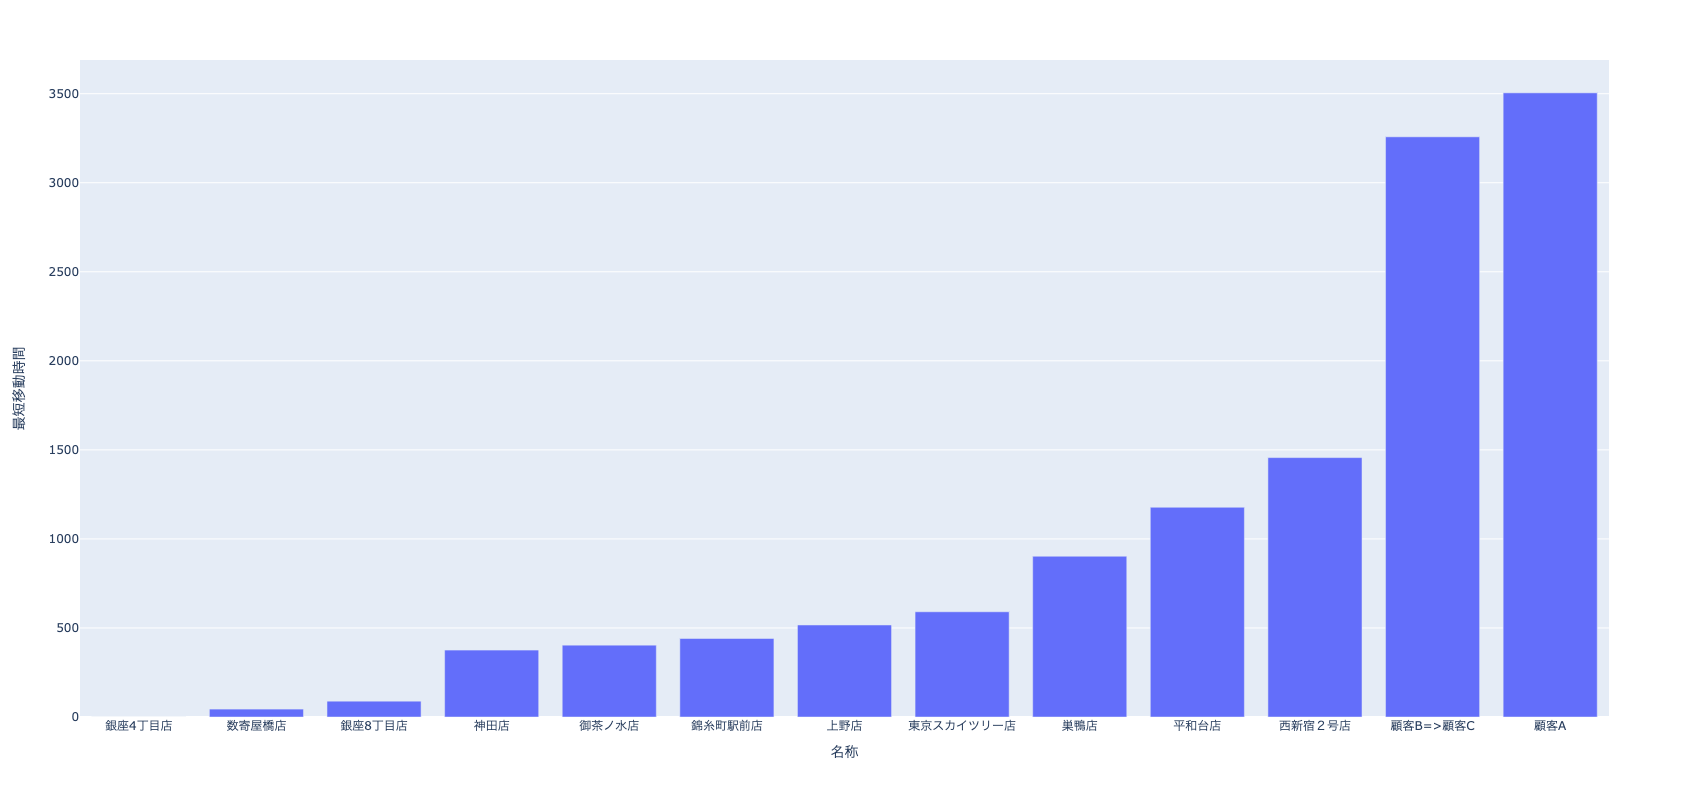

In [ ]:
#| hide_input
Image("../figure/make_time_fig1.png")

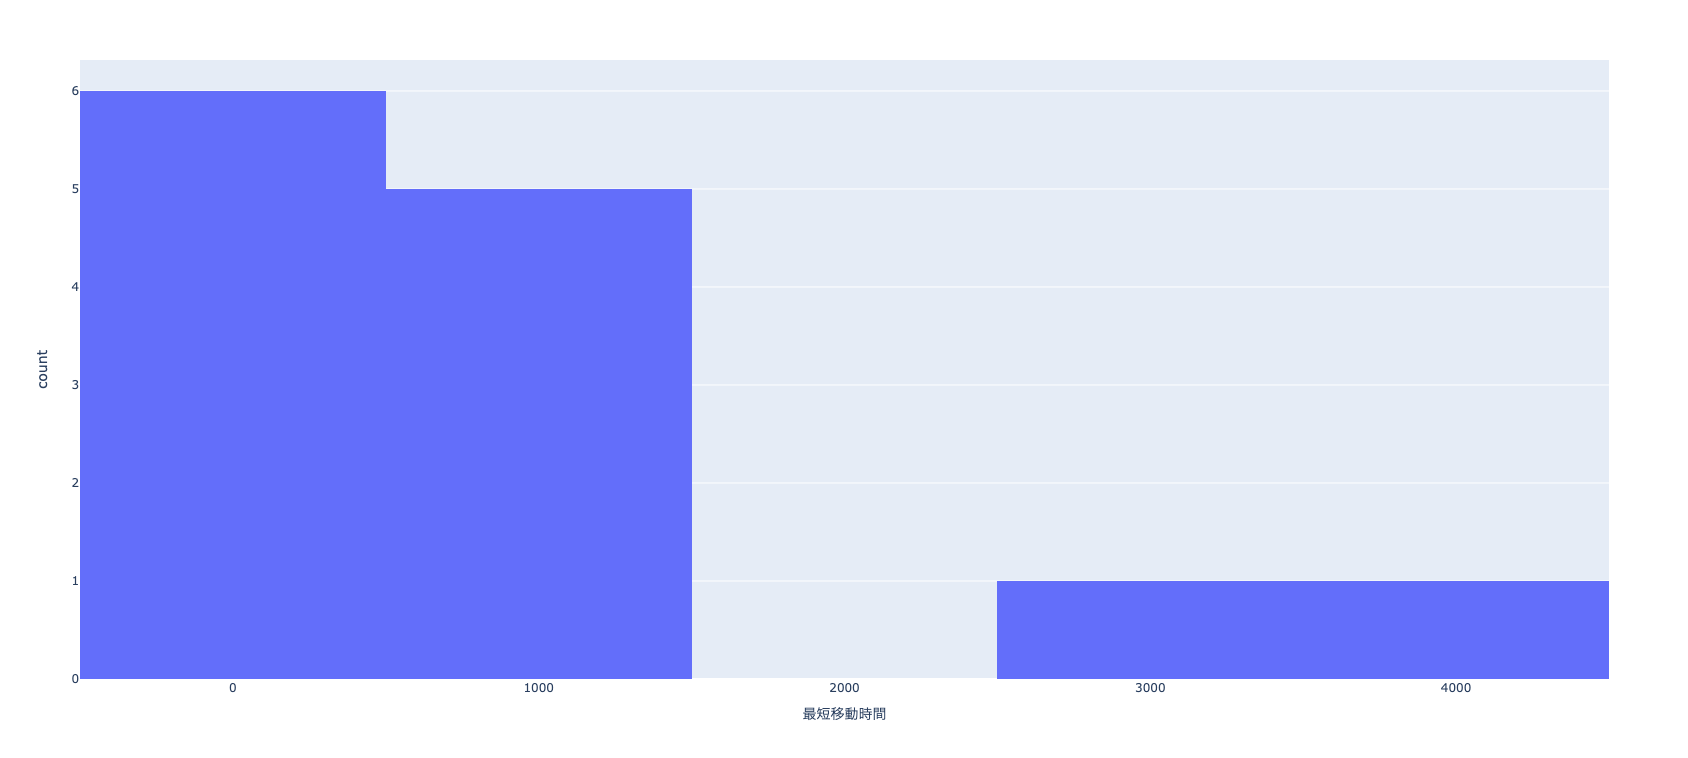

In [ ]:
#| hide_input
Image("../figure/make_time_fig2.png")

### Excel用のデータフレームを用いた時間枠を可視化する関数 make_tw_fig_for_excel

引数：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム
- num_dim: 積載重量の次元数; 既定値は $1$ 
- num_tw: 時間枠の数; 既定値は $1$ 

返値：
- fig: Plotlyの図オブジェクト

In [ ]:
#| export
def make_tw_fig_for_excel(job_df, shipment_df, vehicle_df, num_dim = 1, num_tw = 1):
    """
    Excel用のデータフレームを用いた時間枠を可視化する関数
    """
    start = vehicle_df.iloc[:,5].min()
    #print(start)
    finish = vehicle_df.iloc[:,6].max()
    L = []
    for row in job_df.itertuples():
        for j in range(num_tw):
            if pd.isnull(row[5+j*2]):
                L.append(dict(Task=f"時間枠 {j}", Start= start.strftime('%Y-%m-%d %H:%M'), Finish=finish.strftime('%Y-%m-%d %H:%M'), Resource=row[1]))
            else:
                tw0 = row[5+j*2]
                tw1 = row[6+j*2]
                L.append(dict(Task=f"時間枠 {j}", Start= tw0.strftime('%Y-%m-%d %H:%M'), Finish=tw1.strftime('%Y-%m-%d %H:%M'), Resource=row[1]))
                
    for row in shipment_df.itertuples():
        for j in range(num_tw): 
            if pd.isnull(row[num_dim+5+j*2]):
                L.append(dict(Task=f"時間枠 {j}", Start= start.strftime('%Y-%m-%d %H:%M'), Finish=finish.strftime('%Y-%m-%d %H:%M'), Resource=row[num_dim+1]))
            else:
                tw0 = row[num_dim+5+j*2]
                tw1 = row[num_dim+6+j*2]  
                L.append(dict(Task=f"積み込み時間枠 {j}", Start= tw0.strftime('%Y-%m-%d %H:%M'), 
                              Finish=tw1.strftime('%Y-%m-%d %H:%M'), Resource=row[num_dim+1]))
            
            if pd.isnull(row[num_dim+9+num_tw*2+j*2]):
                L.append(dict(Task=f"時間枠 {j}", Start= start.strftime('%Y-%m-%d %H:%M'), Finish=finish.strftime('%Y-%m-%d %H:%M'), Resource=row[num_dim+4+num_tw*2+1]))
            else:
                tw0 = row[num_dim+9+num_tw*2+j*2]
                tw1 = row[num_dim+10+num_tw*2+j*2]
                L.append(dict(Task=f"積み降ろし時間枠 {j}", Start= tw0.strftime('%Y-%m-%d %H:%M'), Finish=tw1.strftime('%Y-%m-%d %H:%M'), 
                              Resource=row[num_dim+4+num_tw*2+1]))
    df = pd.DataFrame( L ) 
#    print(L)
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Resource", color="Task")
    return fig

#### make_tw_fig_for_excel関数の適用例

In [ ]:
wb = load_workbook("metro-ex2.xlsx")
job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
job_df

,名称,作業時間（分）,経度（小数),緯度(小数),最早時刻1,最遅時刻1,積み込み量1,積み降ろし量1,スキル1（0か1),優先度（1..100)
0,東京都目黒区鷹番1-1-4,10.0,139.719235,35.710933,08:00:00,15:00:00,1000.0,0.0,NaN,None
1,東京都台東区松が谷1-1-1,10.0,139.789779,35.708197,08:00:00,15:00:00,1000.0,0.0,NaN,None
2,東京都墨田区業平1-5-3,10.0,139.813112,35.705036,08:00:00,15:00:00,150.0,0.0,NaN,None
3,東京都台東区小島2-8-14,10.0,139.786417,35.702642,12:00:00,15:00:00,200.0,0.0,NaN,None
4,東京都江戸川区中葛西5-40-15,10.0,139.869792,35.658917,12:00:00,15:00:00,165.0,100.0,NaN,None
...,...,...,...,...,...,...,...,...,...,...
85,川崎市宮前区菅生3-41-14,10.0,139.551161,35.592292,08:00:00,15:00:00,250.0,0.0,NaN,None
86,逗子市逗子7-2-38,10.0,139.577569,35.292989,08:00:00,15:00:00,250.0,0.0,NaN,None
87,横浜市都筑区川向町922-40,10.0,139.593376,35.513112,08:00:00,15:00:00,150.0,0.0,NaN,None
88,横浜市都筑区大棚町64,10.0,139.597258,35.545043,08:00:00,15:00:00,50.0,0.0,NaN,None


In [ ]:
fig = make_tw_fig_for_excel(job_df, shipment_df, vehicle_df, num_dim=1, num_tw = 1)
plotly.offline.plot(fig);

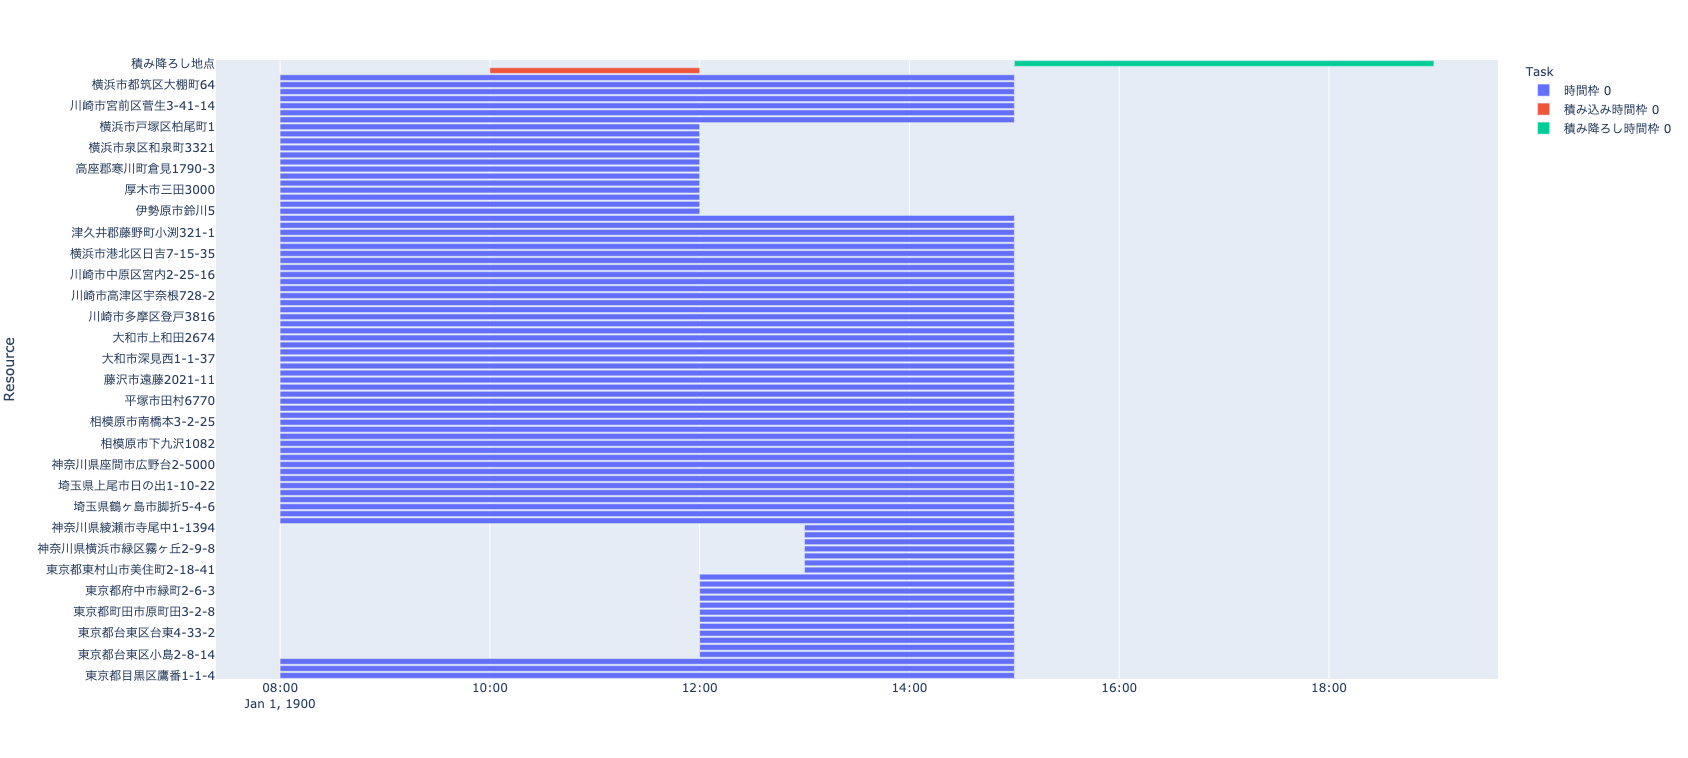

In [ ]:
#| hide_input
Image("../figure/make_tw_fig_for_excel.png")

In [ ]:
#| hide
# #2次元の場合の可視化
# fig = {}
# for i in range(num_dim):
#     x, y = [],[]
#     for row in job_df.itertuples():
#         x.append(row[4+num_tw*2+1+i*2])
#         y.append(row[4+num_tw*2+2+i*2])
#     fig[i] = px.scatter(x=x, y=y)
# plotly.offline.plot(fig[1]);

In [ ]:
#| hide
#異常検知
# from pycaret.anomaly import *
# anomaly = setup(job_df.iloc[:,4+num_tw*2:4+num_tw*2+2*num_dim], normalize=True, silent=True, verbose=False, session_id =123)
# iforest = create_model('iforest')
# iforest_results = assign_model(iforest)
# #plot_model(iforest, plot = 'umap', save=True)
# iforest_results.sort_values("Anomaly_Score").tail(50)

### 荷量簡易分析関数 analyze_load

ジョブの荷量が運搬車の積載量上限でまかなえるかを，線形最適化を用いて簡易的に分析することを考える．

荷量は複数の属性をもつ場合があるので，多次元のベクトルとして扱う．その次元数と積み込み・積み降ろしの区別をするので，全体で「次元数$\times$2」の資源制約をもつと考える．

次元の添字を $j$，積み込み・積み降ろしの添字を $k　(=0,1)$ とし， $j,k$ の組を資源とよぶ．

ジョブ（顧客）を運搬車に割り当てる際には，スキルを考慮する必要がある．顧客のスキル集合が運搬車のスキル集合の部分集合になっている場合に割り当て可能になる．

以下のパラメータと変数を導入する．

パラメータ
- $d_{ijk}$: 顧客 $i$ の資源 $j,k$ の荷量
- $C_{vj}$: 運搬車 $v$ の次元 $j$ の積載量上限
- $M$: 大きな数（超過ペナルティを優先するために用いる．）
- $\epsilon$: 小さな数（不用意な超過・余裕量を $0$ にするため．）

変数
- $x_{iv}$: 顧客 $i$ を運搬車 $v$ に割り当てる割合； 顧客 $i$ のスキルが運搬車 $v$ のスキル集合の部分集合になっているときだけ定義する．
- $surplus_{vjk}$: 運搬車 $v$ の資源 $j,k$ の超過量の割合
- $slack_{vjk}$: 運搬車 $v$ の資源 $j,k$ の余裕量の割合
- $y$: 最大の超過割合
- $z$: 最小の割合

定式化
$$
\begin{array}{lll} 
  minimize & My-z +\epsilon \sum_{v,j,k} (surplus_{vjk}+slack_{vjk}) &    \\
  s.t.     &   \sum_{v} x_{iv} = 1 & \forall i \\
           & \sum_{i} d_{ijk} x_{iv}   = C_{vj}(1- slack_{vjk} +surplus_{vjk})  & \forall v,j,k \\
           & 0 \leq slack_{vjk} \leq z   & \forall v,j,k \\
           & 0 \leq surplus_{vjk} \leq y   & \forall v,j,k \\
           & x_{iv} \geq 0        & \forall i,v
\end{array}
$$



引数：
- job_df: ジョブデータフレーム
- vehicle_df: 運搬車データフレーム
- num_dim: 積載重量の次元数; 既定値は $1$ 
- num_tw: 時間枠の数; 既定値は $1$ 
- num_skill: スキル数; 既定値は $1$ 

返値：
- fig_surplus: 超過のPlotly図オブジェクト
- fig_slack: 不足量のPlotly図オブジェクト

In [ ]:
#| export
def analyze_load(job_df, vehicle_df, num_dim=1, num_tw = 1, num_skill = 1):
    demand = {}
    skill = {}
    for i,row in enumerate(job_df.itertuples()):
        for j in range(2*num_dim):
            demand[i,j] = row[5+2*num_tw+j]
        skill[i] = set([])
        for k in range(num_skill):
            if pd.isnull(row[5+2*num_tw+2*num_dim+k]):
                pass
            elif row[5+2*num_tw+2*num_dim+k]>0: 
                skill[i].add(k)

    v_skill ={}
    capacity ={}
    vehicle_name ={}
    for v,row in enumerate(vehicle_df.itertuples()):
        vehicle_name[v] = row[1]
        for j in range(num_dim):
            capacity[v,j] = row[8+j]
        v_skill[v] = set([])
        for k in range(num_skill):
            if pd.isnull(row[8+num_dim+k]):
                pass
            elif row[8+num_dim+k]>0:
                v_skill[v].add(k)

    model = PulpModel()
    x = {}
    m = len(job_df)
    n = len(vehicle_df)
    for i in range(m):
        for v in range(n):
            if skill[i]<=v_skill[v]:
                x[i,v] = model.addVar(name=f"x({i},{v})", vtype="C")
    surplus, slack ={},{}
    for v in range(n):
        for j in range(num_dim):
            slack[v,j,0] = model.addVar(name=f"slack({v},{j},0)", vtype="C") #for pickup
            slack[v,j,1] = model.addVar(name=f"slack({v},{j},1)", vtype="C") #for delivery
            surplus[v,j,0] = model.addVar(name=f"surplus({v},{j},0)", vtype="C") #for pickup
            surplus[v,j,1] = model.addVar(name=f"surplus({v},{j},1)", vtype="C") #for delivery
    y = model.addVar(name ="y", vtype="C") #超過の最大値
    z = model.addVar(name ="z", vtype="C") #スラックの最小値
    model.update()
    #割当制約
    for i in range(m):
        model.addConstr(quicksum(x[i,v] for v in range(n) if (i,v) in x) == 1, name=f"Assign({i})")
    #容量制約
    for v in range(n):
        for j in range(num_dim):
            model.addConstr(quicksum(demand[i,j]*x[i,v] for i in range(m) if (i,v) in x) + capacity[v,j]*slack[v,j,0] 
                            == capacity[v,j]+ capacity[v,j]*surplus[v,j,0], name=f"pickup({v},{j})")   #積み込み上限
            model.addConstr(quicksum(demand[i,num_dim+j]*x[i,v] for i in range(m) if (i,v) in x) + capacity[v,j]*slack[v,j,1] 
                            == capacity[v,j] + capacity[v,j]*surplus[v,j,1], name=f"delivery({v},{j})") #積み降ろし上限
    #最小のスラックを最大化
    for v in range(n):
        for j in range(num_dim):
            for k in range(2):
                model.addConstr(slack[v,j,k]>=z, name=f"slack_min({v},{j},{k})")
    #最大の超過を最小化
    for v in range(n):
        for j in range(num_dim):
            for k in range(2):
                model.addConstr(surplus[v,j,k]<=y, name=f"surplus_max({v},{j},{k})")
    #超過は最小化（第１目的）；スラックの最小値の最大化（第２目的）
    model.setObjective(-z + 999999.*y + .01* quicksum(surplus[v,j,k]+slack[v,j,k] for v in range(n) for j in range(num_dim) for k in range(2)), GRB.MINIMIZE)
    model.optimize()
    # for (i,v) in x:
    #     if x[i,v].X > 0.001:
    #         print(i,v,x[i,v].X)

    v_list, j_list, k_list,val_list =[],[],[],[]
    for v in range(n):
        for j in range(num_dim):
            for k in range(2):
                v_list.append(vehicle_name[int(v)])
                j_list.append(j+1)
                if k==0:
                    k_list.append("積み込み")
                else:
                    k_list.append("積み降ろし")
                val_list.append(surplus[v,j,k].X)
                #if surplus[v,j,k].X > 0:
                #    print(v,j,k,surplus[v,j,k].X)   
    df = pd.DataFrame({"運搬車":v_list, "荷量次元": j_list, "積み込み・積み降ろし":k_list, "超過":val_list})
    fig_surplus = px.bar(df, x="運搬車", y="超過", facet_row="荷量次元", facet_col="積み込み・積み降ろし", range_y=[0,1])

    v_list, j_list, k_list,val_list =[],[],[],[]
    for v in range(n):
        for j in range(num_dim):
            for k in range(2):
                v_list.append(vehicle_name[int(v)])
                j_list.append(j+1)
                if k==0:
                    k_list.append("積み込み")
                else:
                    k_list.append("積み降ろし")
                val_list.append(slack[v,j,k].X)
                #print(v,j,k,slack[v,j,k].X)
    #print(model.ObjVal,z.X)
    df = pd.DataFrame({"運搬車":v_list, "荷量次元": j_list, "積み込み・積み降ろし":k_list, "余裕":val_list})
    fig_slack = px.bar(df, x="運搬車", y="余裕", facet_row="荷量次元", facet_col="積み込み・積み降ろし", range_y=[0,1])
    return fig_surplus, fig_slack 

#### analyze_loadの使用例


In [ ]:
wb = load_workbook("metro-ex2.xlsx")
job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)

fig_surplus, fig_slack = analyze_load(job_df, vehicle_df, num_dim=1, num_tw = 1, num_skill = 1)

plotly.offline.plot(fig_slack);
plotly.offline.plot(fig_surplus);

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mikiokubo/miniconda3/envs/scmopt2/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/a66fd6f2c3004ba682d11ee4eb55f949-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/a66fd6f2c3004ba682d11ee4eb55f949-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 143 COLUMNS
At line 1730 RHS
At line 1869 BOUNDS
At line 2624 ENDATA
Problem MODEL has 138 rows, 754 columns and 1552 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 121 (-17) rows, 730 (-24) columns and 1512 (-40) elements
Perturbing problem by 0.001% of 46.385961 - largest nonzero change 0.00014319111 ( 15.765%) - largest zero change 0
0  Obj 0.16 Primal inf 61.851537 (89) Dual inf 0.70957791 (713)
0  Obj 0.16 Primal inf 61.851537 (89) Du

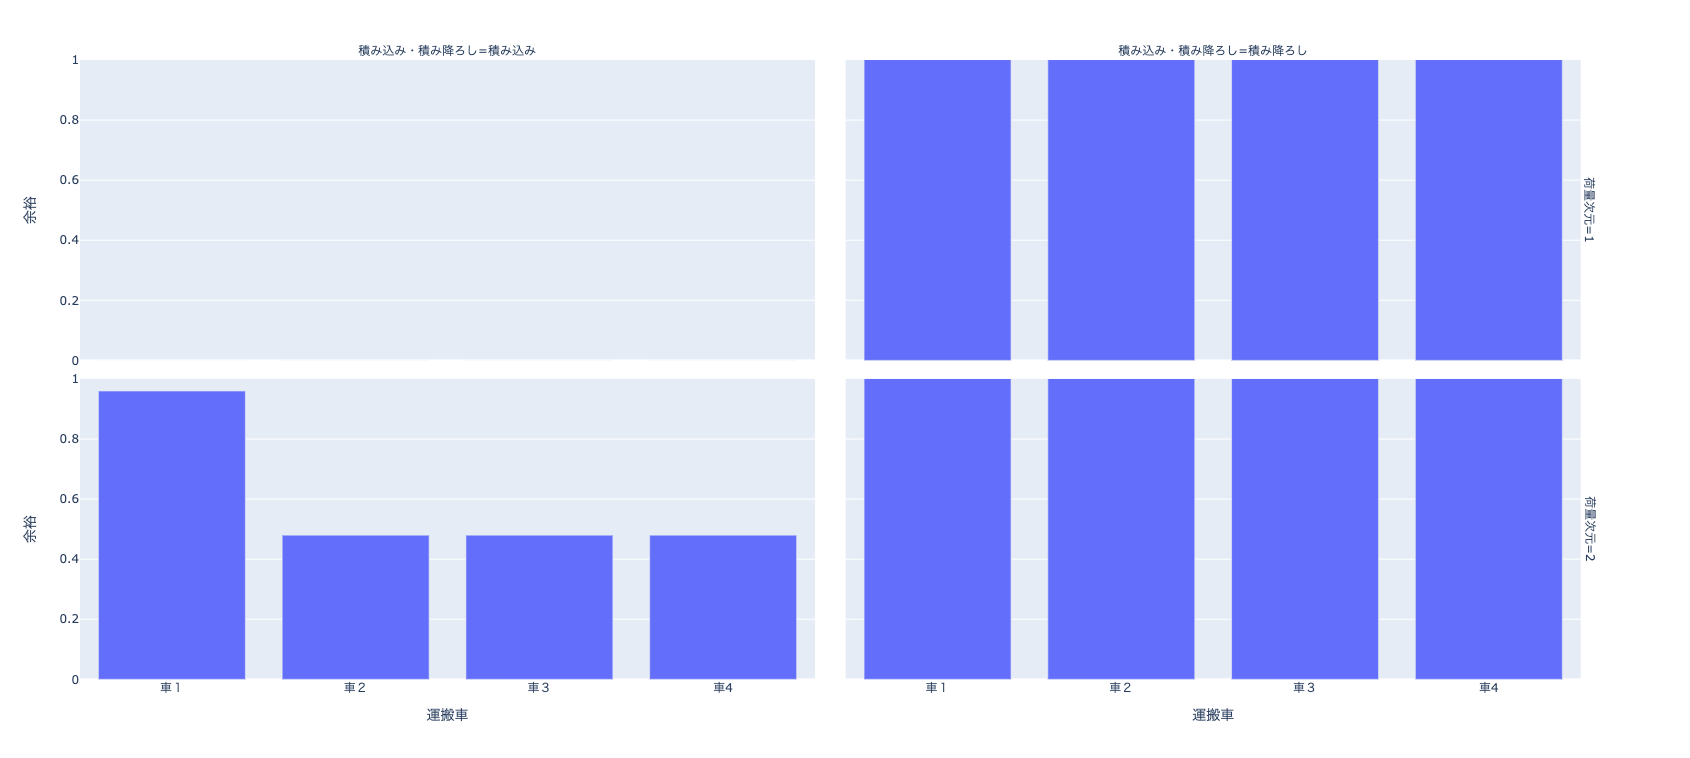

In [ ]:
#| hide_input
Image("../figure/fig_slack.png")

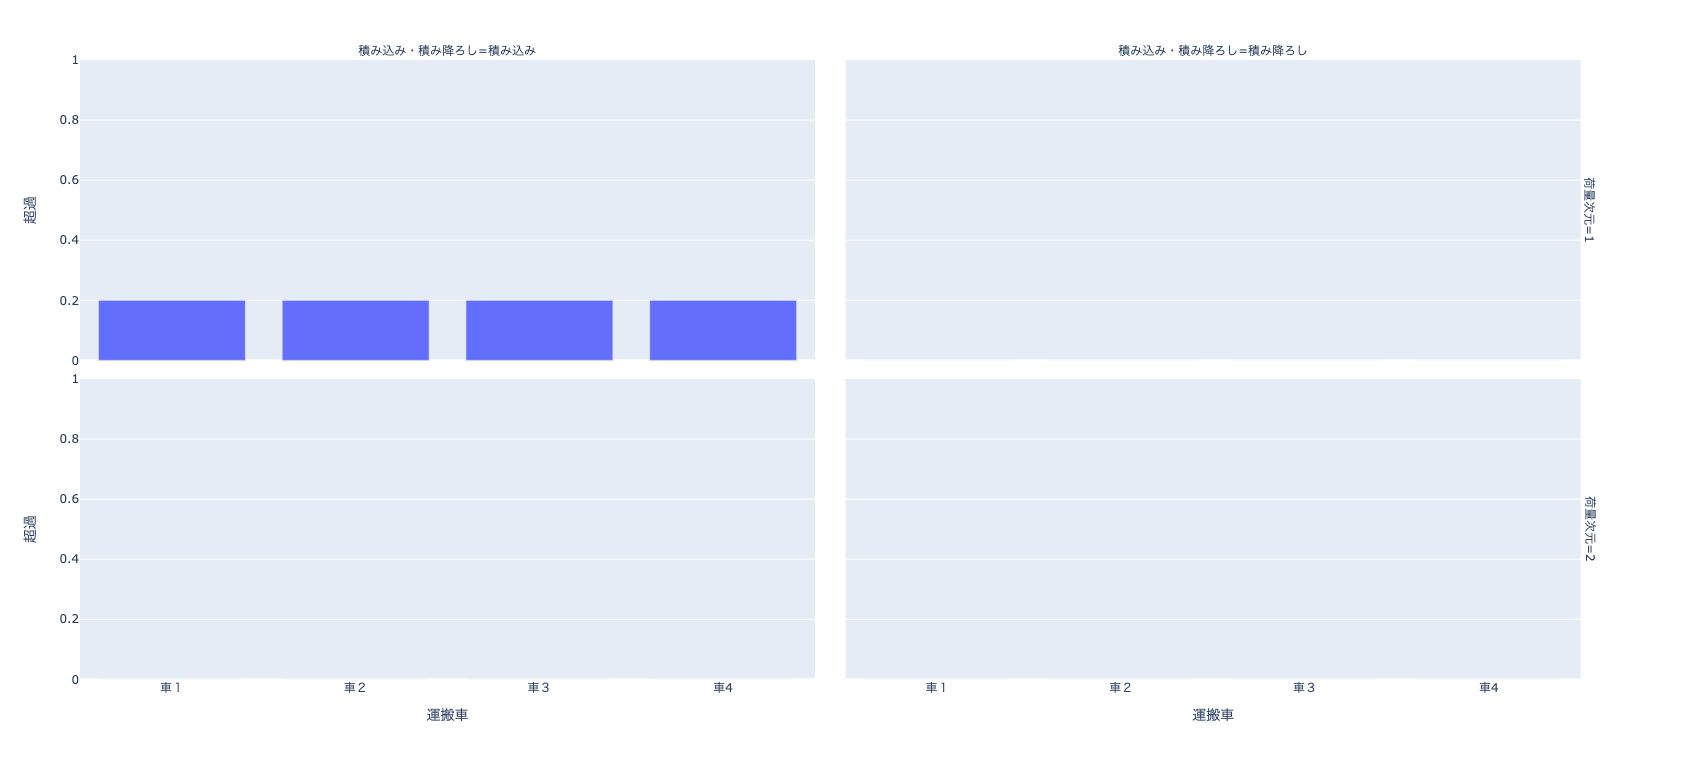

In [ ]:
#| hide_input
Image("../figure/fig_surplus.png")

### 荷量のヒストグラムを作成する関数 show_load

In [ ]:
#| export
def show_load(job_df, num_dim=1, num_tw=1):
    demand = {}
    for i,row in enumerate(job_df.itertuples()):
        for j in range(2*num_dim):
            demand[i,j] = row[5+2*num_tw+j]
    c_list, j_list, k_list,val_list =[],[],[],[]
    for i,row in enumerate(job_df.itertuples()):
        for j in range(num_dim):
            for k in range(2): #k=0 pickup, k=1 delivery 
                c_list.append(row[1]) #顧客名
                j_list.append(j+1)
                if k==0:
                    k_list.append("積み込み")
                else:
                    k_list.append("積み降ろし")
                val_list.append(demand[i,num_dim*k+j])
    df = pd.DataFrame({"顧客": c_list, "荷量次元": j_list, "積み込み・積み降ろし":k_list, "荷量":val_list})
    df.sort_values("荷量", inplace=True, ascending=False)
    fig_hist = px.histogram(df, x= "荷量", facet_row="荷量次元", facet_col="積み込み・積み降ろし")
    fig_bar = px.bar(df, x= "荷量", y="顧客", facet_row="荷量次元", facet_col="積み込み・積み降ろし")
    return fig_bar, fig_hist

#### show_load関数の使用例

In [ ]:
wb = load_workbook("metro-ex3.xlsx")
job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
num_dim= 1
num_tw = 1
fig_bar, fig_hist = show_load(job_df, num_dim=num_dim, num_tw=num_tw)
plotly.offline.plot(fig_hist);
plotly.offline.plot(fig_bar);

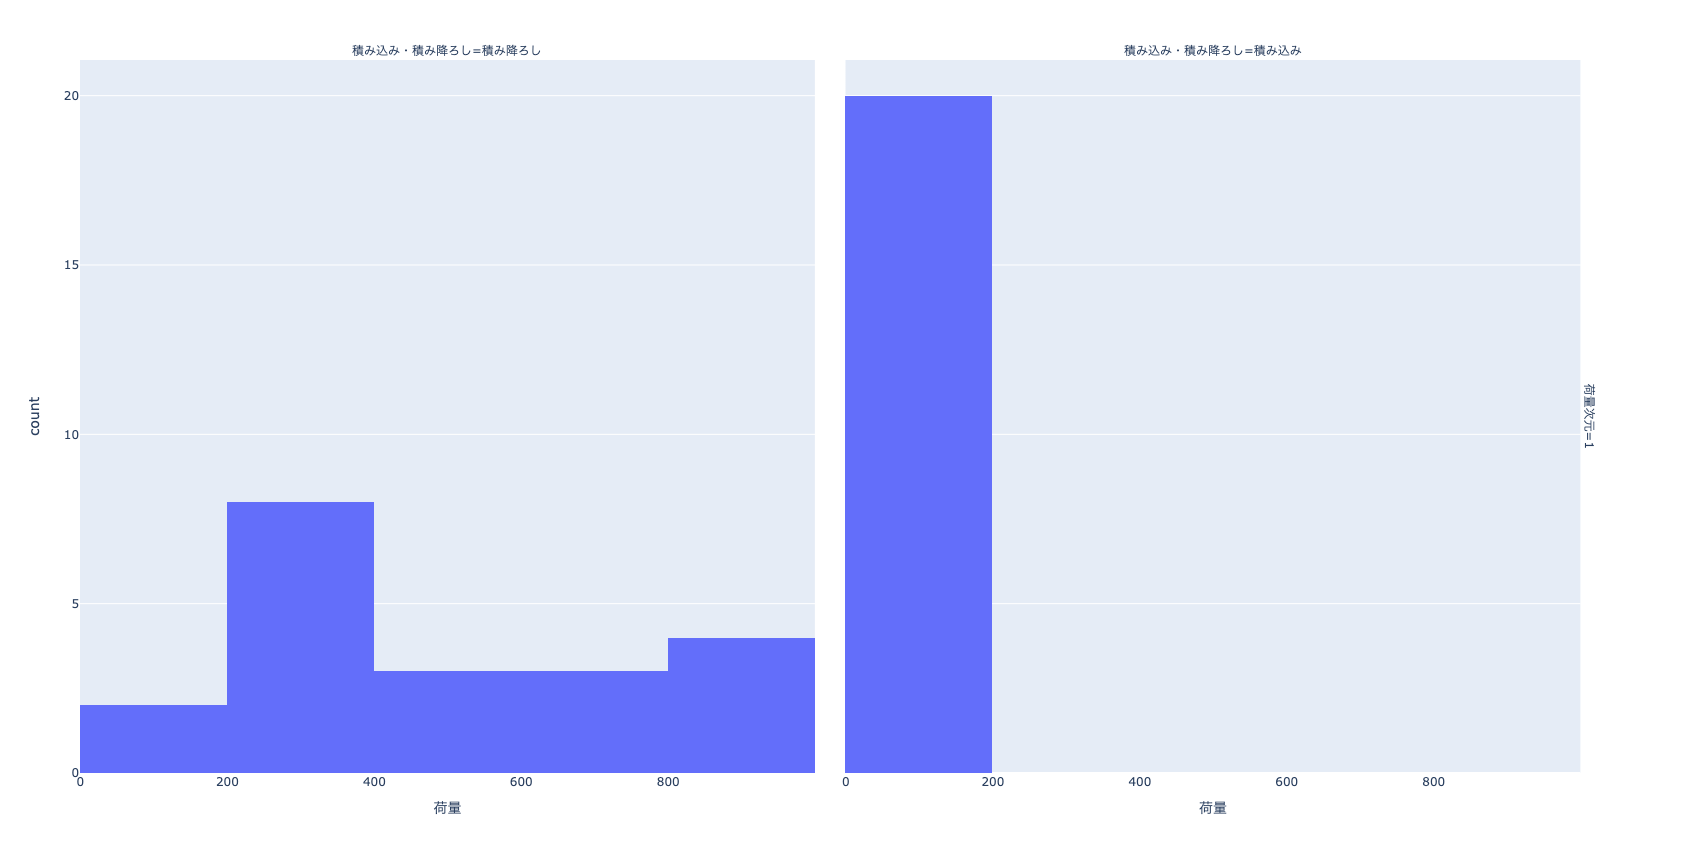

In [ ]:
#| hide_input
Image("../figure/show_load_hist.png")

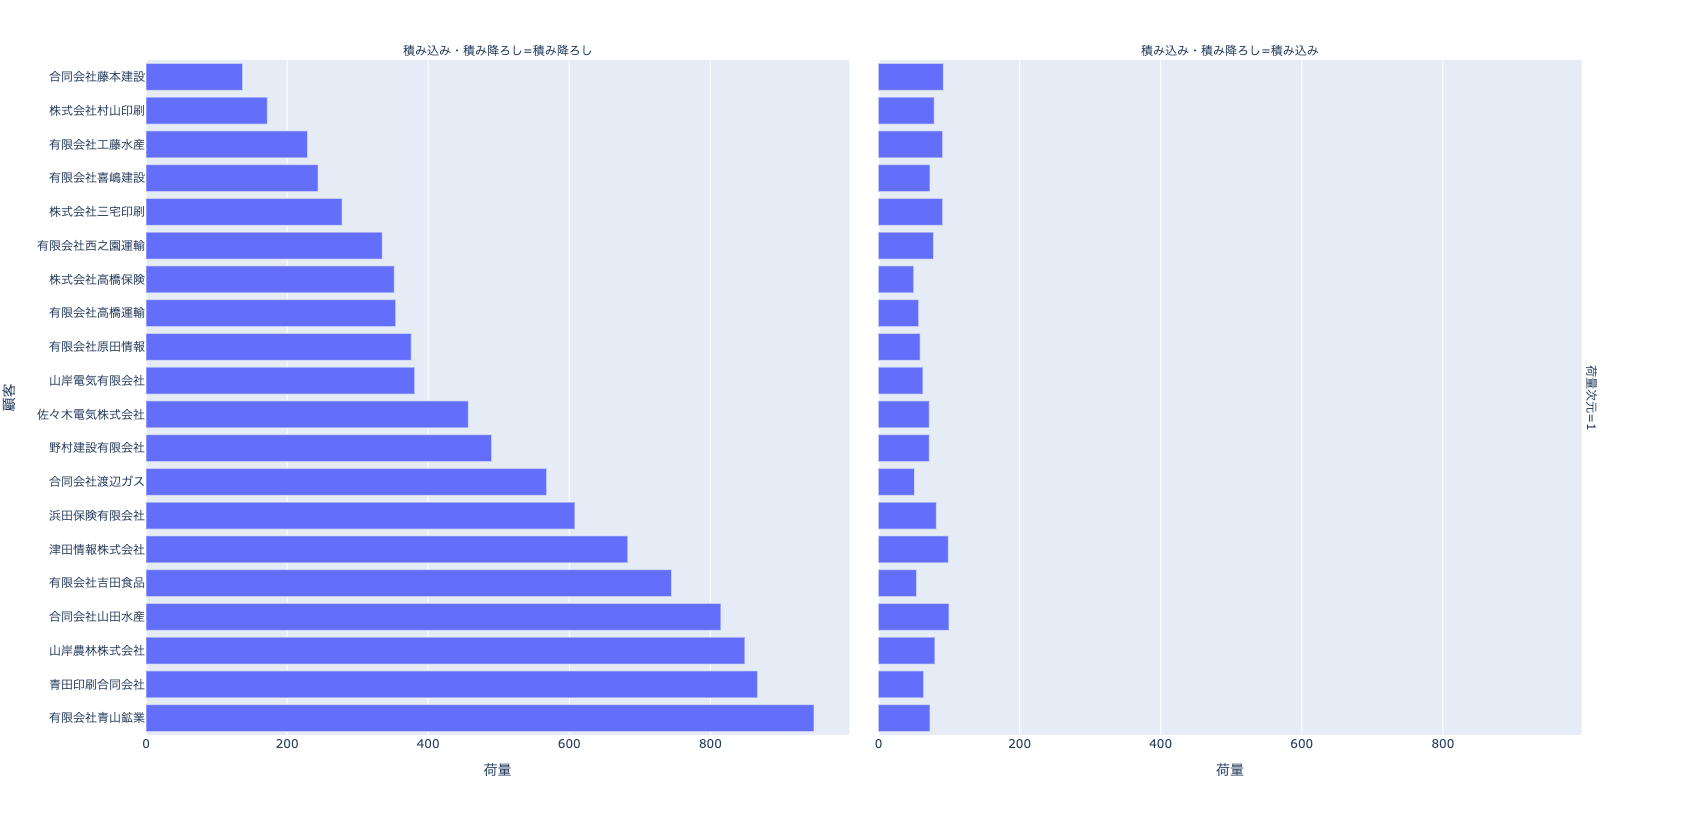

In [ ]:
#| hide_input
Image("../figure/show_load_bar.png")

### Excelから読んだデータフレームを最適化用のデータフレームに変換する関数 create_dfs_from_excel

引数：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム
- break_df: 休憩データフレーム
- num_dim: 積載重量の次元数; 既定値は $3$ 
- num_tw: 時間枠の数; 既定値は $3$ 
- num_skill: スキル数; 既定値は $3$ 
- num_break: 休憩数; 既定値は $3$ 
- date_flag: 時間入力を日付時刻型にする場合 True（既定値）， 時刻型にする場合 False （未使用）

返値：
- job_df: （最適化用の）ジョブデータフレーム
- shipment_df: （最適化用の）輸送データフレーム
- vehicle_df: （最適化用の）運搬車データフレーム
- break_df: （最適化用の）休憩データフレーム
- start: 運搬車の最早開始時刻


In [ ]:
#| export
def create_dfs_from_excel(job_df, shipment_df, vehicle_df, break_df, num_dim = 1, 
                          num_tw = 1, num_skill = 1, num_break=1, date_flag = False):
    #運搬車の最早開始時刻
    start = vehicle_df.iloc[:,5].min()
    finish = vehicle_df.iloc[:,6].max()
    max_time = time_delta(finish,start)
    #job_df
    name, service, delivery, pickup, location, time_windows, skills, priority = [],[],[],[],[],[],[],[]
    location_index = [] 
    for row in job_df.itertuples():
        try:
            location_index.append( int(row.location_index) )
        except:
            location_index.append( -1 )
            
        name.append(str(row[1]))
        service.append( int(row[2]*60) )  #作業時間（分）を秒に変換 [600]
        location.append( f"[{row[3]},{row[4]}]" ) #経度緯度
        TW =[ ]
        col = 5
        for j in range(num_tw):
            if pd.isnull(row[col+2*j]) or pd.isnull(row[col+1+2*j]):
                pass   #入力がない場合には追加しない！
            else:
                early = max(time_delta(row[col+2*j],start),0)
                late = max(time_delta(row[col+1+2*j],start),0) 
                if early >= late:
                    #print(early, late, row[col+2*j], row[col+1+2*j])
                    raise ValueError("時間枠が不正です．")
                TW.append( [early, late] )
        # TWが空の場合には運搬車の最大時間とする．
        if len(TW)==0:
            TW = f"[[0,{max_time}]]"
        time_windows.append( str(TW) )
        PICK, DELI =[], []
        col += num_tw*2
        for j in range(num_dim): #積み込み量
            try:
                PICK.append( int(row[col+j]) )
            except:
                PICK.append(0)
        col += num_dim

        for j in range(num_dim): #積み降ろし量
            try:
                DELI.append( int(row[col+j]) )
            except:
                DELI.append(0) 
        pickup.append( str(PICK ))
        delivery.append( str(DELI ))
        col += num_dim
        
        SKILL =[0] #少なくとも1つのスキルをもつ
        for j in range(num_skill):
            if pd.isnull(row[col+j]):
                pass  #行がNoneの場合は何も追加しない
            elif row[col+j]>0: #j番目のスキルをもつ
                SKILL.append(j+1)
        skills.append( str(SKILL) )
        col += num_skill
        try:
            priority.append( int(row[col]) )
        except:
            priority.append(1)
    job_df = pd.DataFrame( {"name": name, 
                            "service": service,
                            "location": location, 
                            "time_windows": time_windows,
                            "pickup": pickup, 
                            "delivery": delivery, 
                            "skills": skills, 
                            "priority": priority,
                            "location_index": location_index
                           })

    #shipment_df
    amount, pick_name, pick_loc, pick_tw, pick_service, del_name, del_loc, del_service, del_tw, skills, priority = [],[],[],[],[],[],[],[],[],[],[]
    pickup_index, delivery_index = [], [] 
    
    for row in shipment_df.itertuples():
        try:
            pickup_index.append( int(row.pickup_index) )
        except:
            pickup_index.append( -1 ) 
        try:
            delivery_index.append( int(row.delivery_index) )
        except:
            delivery_index.append( -1 )
            
        AMOUNT =[]
        col = 1
        for j in range(num_dim):
            try:
                AMOUNT.append( int(row[col+j]) )
            except:
                AMOUNT.append(0) #なにもない場合には0を入れる！
        amount.append( str(AMOUNT) )
        col = num_dim +1  
        pick_name.append(str(row[col]))
        col +=1
        try:
            pick_service.append( int(row[col]*60) )  #作業時間（分）を秒に変換 [600]
        except:
            pick_service.append( 0 )
        col +=1
        pick_loc.append( f"[{row[col]},{row[col+1]}]" ) #経度緯度
        TW =[ ]
        col +=2
        for j in range(num_tw):
            if pd.isnull(row[col+2*j]) or pd.isnull(row[col+1+2*j])  :
                pass   #入力がない場合には追加しない！
            else:
                early = max(time_delta(row[col+2*j],start),0)
                late = max(time_delta(row[col+1+2*j],start),0) 
                if early >= late:
                    raise ValueError("時間枠が不正です．")
                TW.append( [early, late] )
        if len(TW)==0:
            TW = f"[[0,{max_time}]]"
        pick_tw.append( str(TW) )
        col += num_tw*2
        #delivery
        del_name.append(str(row[col]))
        col +=1
        try:
            del_service.append( int(row[col]*60) )  #作業時間（分）を秒に変換 [600]
        except:
            del_service.append( 0 )
        col +=1
        del_loc.append( f"[{row[col]},{row[col+1]}]" ) #経度緯度
        TW =[ ]
        col +=2
        for j in range(num_tw):
            if pd.isnull(row[col+2*j]) or pd.isnull(row[col+1+2*j])  :
                pass   #入力がない場合には追加しない！
            else:
                early = max(time_delta(row[col+2*j],start),0)
                late = max(time_delta(row[col+1+2*j],start),0) 
                if early >= late:
                    raise ValueError("時間枠が不正です．")
                TW.append( [early, late] )
        if len(TW)==0:
            TW = f"[[0,{max_time}]]"                
        del_tw.append( str(TW) )
        col += num_tw*2    
        SKILL =[0]
        for j in range(num_skill):
            try: #行がNoneの場合は何も追加しない
                if row[col+j]>0: #j番目のスキルをもつ
                    SKILL.append(j+1)
            except:
                pass 
        skills.append( str(SKILL) )
        col += num_skill
        try:
            priority.append( int(row[col]) )
        except:
            priority.append( 1 )
    shipment_df = pd.DataFrame({"amount": amount,
            "pickup_point": pick_name, 
            "pickup_service": pick_service,
            "pickup_time_windows":pick_tw, 
            "pickup_location": pick_loc,                          
            "delivery_point": del_name, 
            "delivery_service": del_service,
            "delivery_time_windows":del_tw, 
            "delivery_location": del_loc,
            "skills": skills, "priority": priority,
            "pickup_index": pickup_index, 
            "delivery_index": delivery_index
            }) 
    
    #vehicle_df
    name, st, end, capacity, time_window, skills, breaks = [],[],[],[],[],[],[]
    start_index, end_index = [], [] 
    for row in vehicle_df.itertuples():
        try:
            start_index.append( int(row.start_index) )
        except:
            start_index.append( -1 )
        try:
            end_index.append( int(row.end_index) )
        except:
            end_index.append( -1 )
            
        col = 1 
        name.append(str(row[col]))
        col +=1
        if pd.isnull(row[col]) or pd.isnull(row[col+1]):
            st.append("[]")
        else:
            st.append( f"[{row[col]},{row[col+1]}]" ) #出発経度緯度
        col +=2
        if pd.isnull(row[col]) or pd.isnull(row[col+1]):
            end.append("[]")
        else:
            end.append( f"[{row[col]},{row[col+1]}]" ) #到着経度緯度
        col +=2
        time_window.append( f"[{time_delta(row[col],start)}, {time_delta(row[col+1],start)}]" )
        col +=2    
        CAP =[]
        for j in range(num_dim):
            try:
                CAP.append( int(row[col+j]) )
            except:
                CAP.append(0)
        capacity.append( str(CAP) )
        col+=num_dim  
        SKILL =[0]
        for j in range(num_skill):
            try: #行がNoneの場合は何も追加しない
                if row[col+j]>0: #j番目のスキルをもつ
                    SKILL.append(j+1)
            except:
                pass 
        skills.append( str(SKILL) )
        col += num_skill
        BREAK =[ ]
        for j in range(num_break):
            try: #行がNoneの場合は何も追加しない
                if row[col+j]>0: #j番目の休憩（順番は0から）
                    BREAK.append(j)
            except:
                pass 
        breaks.append( str(BREAK) )
    vehicle_df = pd.DataFrame({"name": name,
            "start": st, 
            "end": end,
            "time_window": time_window, 
            "capacity": capacity, 
            "skills": skills,
            "breaks": breaks,
            "start_index": start_index,
            "end_index": end_index              
            }) 
    #break_df
    description, time_windows, service= [],[],[]
    for row in break_df.itertuples():
        col = 1 
        description.append(str(row[col]))
        col +=1
        if pd.isnull(row[col]) or pd.isnull(row[col+1]):
            time_windows.append( f"[(0,{max_time})]" )
        else:
            time_windows.append( f"[({max(time_delta(row[col],start),0)}, {time_delta(row[col+1],start)})]" )
        col+=2
        if pd.isnull(row[col]):
            service.append(0)
        else:
            service.append( int(row[col]*60) )
    break_df = pd.DataFrame( {"description": description, "time_windows": time_windows, "service": service} )
    return job_df, shipment_df, vehicle_df, break_df, start

### create_dfs_from_excel関数の実行例

In [ ]:
# num_dim = 2
# num_tw = 2
# num_skill = 2
# num_break=1
# wb = load_workbook("metro-ex1.xlsx")

num_dim = 1
num_tw = 1
num_skill = 1
num_break=1
wb = load_workbook("metro-ex3.xlsx")
# wb = load_workbook("metro_example1.xlsx")
# wb = load_workbook("metro-ex1-tbl.xlsx")
wb, durations, distances = make_table_for_metro(wb, num_dim, num_tw, num_skill, num_break, toll=True, host=host)
job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
job_df, shipment_df, vehicle_df, break_df, start = create_dfs_from_excel(job_df, shipment_df, vehicle_df, break_df, 
                                                                    num_dim, num_tw, num_skill, num_break, date_flag = False)

In [ ]:
time_df = read_time_from_excel(wb)
model = build_model_for_vrp(job_df, shipment_df, vehicle_df,  break_df, time_df)
#model = build_model_for_vrp(job_df, shipment_df, vehicle_df,  break_df)
input_dic, output_dic, error = optimize_vrp(model, matrix=False, explore=5, cloud=False, osrm=True, host=host)
### depreciated route_df_dic, unassigned_job_df, unassigned_shipment_df = make_route_for_vrp(job_df, shipment_df, vehicle_df, break_df, output_dic)

summary_df, route_summary_df, unassigned_df, route_df_dic = make_solution(output_dic)
route_df_dic[0]

Now solving ...
Done


,type,location,location_index,setup,service,waiting_time,load,arrival,duration,violations,distance,description,id,job
0,start,"[139.49149965, 36.00356841]",20,0,0,0,[1838],6447,0,[],0,NaN,NaN,NaN
1,job,"[139.51107504, 35.90863789]",4,0,60,0,[1123],7304,857,[],13780,合同会社山田水産,4,4
2,job,"[139.55317534, 35.83156779]",5,0,60,0,[432],8227,1720,[],25965,有限会社吉田食品,5,5
3,job,"[139.46293794, 35.82373752]",14,0,60,0,[245],9025,2458,[],37687,株式会社三宅印刷,14,14
4,break,NaN,0,0,3600,0,[245],10800,4173,[],64292,NaN,0,NaN
5,end,"[139.49149965, 36.00356841]",20,0,0,0,[245],14400,4173,[],64292,NaN,NaN,NaN


In [ ]:
# model = build_model_for_vrp(job_df, shipment_df, vehicle_df,  break_df)
# pprint(model["vehicles"][1])

In [ ]:
#最適化
#input_dic, output_dic, error = optimize_vrp(model, matrix=False, explore=5, cloud=False)

In [ ]:
#route_df_dic, unassigned_job_df, unassigned_shipment_df = make_route_for_vrp(job_df, shipment_df, vehicle_df, break_df, output_dic)

#ルートデータフレームの最初のルートを表示
#route_df_dic[0]

In [ ]:
#unassigned_shipment_df

In [ ]:
# fig = make_fig_for_vrp(input_dic, output_dic, show_mode="route", map_style = 0 )
# plotly.offline.plot(fig);

In [ ]:
#fig = gannt_for_vrp(route_df_dic, start= "2020/01/01 8:00" )
# fig = gannt_for_vrp(route_df_dic, start= "08:00" )
# plotly.offline.plot(fig);

### 未割り当てのExcelデータを得る関数 unassigned_for_excel

引数：
- job_df: ジョブデータフレーム
- shipment_df: 輸送データフレーム
- vehicle_df: 運搬車データフレーム
- output_dic: 最適化の出力を保管した辞書

返値：
- unassigned_job_df: 未割り当てのジョブデータフレーム
- unassigned_shipment_df: 未割り当ての輸送データフレーム
- unassigned_vehicle_df : 未割り当ての運搬車データフレーム

In [ ]:
#| export
def unassigned_for_excel(job_df, shipment_df, vehicle_df, output_dic):
    """
    Excel用の未割り当てを返す関数
    """
    n_jobs = len(job_df)
    n_thres = n_jobs + len(shipment_df)
    unassigned_job, unassigned_shipment = [], [] 
    for d in output_dic["unassigned"]:
        if  n_jobs <= d["id"]< n_thres: #pickup point 
            shipment_id = d["id"]-n_jobs
            unassigned_shipment.append(shipment_id)
        elif d["id"] <=n_jobs:
            unassigned_job.append( d["id"] )
    unassigned_shipment_df = shipment_df.iloc[ unassigned_shipment, : ]
    unassigned_job_df = job_df.iloc[ unassigned_job, :]
    
    assigned_vehicle = []
    for r in output_dic["routes"]:
        assigned_vehicle.append( r["vehicle"] )
    assigned_vehicle = set(assigned_vehicle)
    unassigned_vehicle =[ ]
    for i in range(len(vehicle_df)):
        if i not in assigned_vehicle:
            unassigned_vehicle.append(i)
    unassigned_vehicle_df = vehicle_df.iloc[unassigned_vehicle, :] 

    return unassigned_job_df, unassigned_shipment_df, unassigned_vehicle_df 

In [ ]:
# #
# wb = load_workbook("metro-ex1.xlsx")
# #wb = load_workbook("metro-ex5.xlsx")
# job_df, shipment_df, vehicle_df, break_df = read_dfs_from_excel(wb)
# job_df0 = job_df.copy()
# shipment_df0 = shipment_df.copy()
# vehicle_df0 = vehicle_df.copy()
            
# job_df, shipment_df, vehicle_df, break_df, start = create_dfs_from_excel(job_df, shipment_df, vehicle_df, break_df, 
#                                                                     num_dim = 2, num_tw = 2, num_skill = 2, num_break=1, date_flag = False)
# model = build_model_for_vrp(job_df, shipment_df, vehicle_df,  break_df)
# input_dic, output_dic, error = optimize_vrp(model, matrix=False, explore=5, cloud=False)
# route_df_dic, unassigned_job_df, unassigned_shipment_df = make_route_for_vrp(job_df, shipment_df, vehicle_df, break_df, output_dic)
# unassigned_job_df, unassigned_shipment_df, unassigned_vehicle_df = unassigned_for_excel(job_df0, shipment_df0, vehicle_df0, output_dic)
# unassigned_vehicle_df

### 結果をExcelシートに書き込む関数 write_result_excel

引数：
- start: 運搬車の最早開始時刻
- output_dic: 最適化で出力されたJSONデータ
- unassigned_job_df: 未割り当てのジョブのデータフレーム
- unassigned_shipment_df: 未割り当ての輸送のデータフレーム
- output_dic: 最適化出力のJSONnum_tw

返値：
- wb: 結果を書き込んだExcel Worksheet

In [ ]:
#| export
def write_result_excel(start, route_df_dic, unassigned_job_df, unassigned_shipment_df, 
                       unassigned_vehicle_df, output_dic, num_tw):
    wb = Workbook()
    ws = wb.active
    wb.remove(ws)

    ws = wb.create_sheet(title="サマリー")
    ws.append(["METRO 最適化サマリー"])

    ws.append(["総移動時間", output_dic["summary"]["cost"]] )
        
    ws.append(["未処理ジョブ"])
    if len(unassigned_job_df) > 0:
        for row in dataframe_to_rows(unassigned_job_df,index=True, header=True):
            ws.append(row)
    ws.append(["未処理輸送"])
    if len(unassigned_shipment_df) > 0:
        for row in dataframe_to_rows(unassigned_shipment_df, index=True, header=True):
            ws.append(row) 
    ws.append(["未使用運搬車"])
    if len(unassigned_vehicle_df) > 0:
        for row in dataframe_to_rows(unassigned_vehicle_df, index=True, header=True):
            ws.append(row) 

    #ルート
    for r in route_df_dic:
        ws = wb.create_sheet(title=f"ルート{r}")
        tw_list = {}
        for i in range(num_tw*2):
            tw_list[i] = []
        arrival = []
        #skills = [ ]
        for row in route_df_dic[r].itertuples():
            arrival.append( add_seconds(start, row[8]) )
            #スキルから既定値の0を除く
            # try:
            #     skill = re.findall(r"\d+", row.skills)
            #     skill.remove("0")
            #     s = []
            #     for i in skill:
            #         s.append(int(i))
            # except:
            #     s = "[]"
            # skills.append(s)
            
        #     tw = re.findall(r"\d+", row[6])
        #     tw_data = list(map(int, tw)) #時間枠のデータ
        #     for i in range(num_tw*2):
        #         try:
        #             tw_list[i].append( add_seconds(start,tw_data[i]) )  
        #         except:
        #             tw_list[i].append("")
        # count = 0
        # for i in range(num_tw):  
        #     route_df_dic[r][f"最早時刻{i+1}"] = tw_list[count]
        #     count+=1
        #     route_df_dic[r][f"最遅時刻{i+1}"] = tw_list[count]
        #     count+=1
            
        route_df_dic[r]["到着時刻"] = arrival                 
        route_df_dic[r]["作業時間"] = route_df_dic[r]["service"]//60
        route_df_dic[r]["経過時間"] = route_df_dic[r]["duration"]//60
        route_df_dic[r]["待ち時間"] = route_df_dic[r]["waiting_time"]//60
        #route_df_dic[r]["skills"] = skills
        route_df_dic[r].rename(columns={"description": "名称"}, inplace=True)
        
        # tw_col =[]
        # for i in range(num_tw):
        #     tw_col.extend([f"最早時刻{i+1}",f"最遅時刻{i+1}"])
        df = route_df_dic[r][["名称", "到着時刻","作業時間","待ち時間", "経過時間"]]
        #df = df.astype({"積み込み量":str,"配達量":str,"積載量":str,"スキル":str})

        for row in dataframe_to_rows(df, index=True, header=True):
            ws.append(row)

    return wb

#### write_result_excel関数の使用例

In [ ]:
unassigned_job_df, unassigned_shipment_df, unassigned_vehicle_df = unassigned_for_excel(job_df, shipment_df, vehicle_df, output_dic)
wb = write_result_excel(start, route_df_dic, unassigned_job_df, unassigned_shipment_df, unassigned_vehicle_df, 
                        output_dic, num_tw=1)
#wb.save("result.xlsx")